# Librerías:

In [44]:
import sys
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import (month_plot, plot_acf, plot_pacf)
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.stattools import durbin_watson
np.random.seed(0)
from scipy.stats import kurtosis, skew
from pathlib import Path

In [2]:
# Función de apoyo para hacer plots
def run_sequence_plot(x, y, title, xlabel="Tiempo", ylabel="Valores", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

In [3]:
def fft_analysis(signal):
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1) # Ajuste recta
    trend = np.arange(len(signal)) * slope + intercept #tendencia lineal para cada punto
    detrended = signal - trend # Eliminación de la tendencia lineal  componentes dominantes
    fft_values = np.fft.fft(detrended) # frecuencias correspondientes a cada componente en la FFT
    frequencies = np.fft.fftfreq(len(fft_values)) #Valores de las frecuencias
    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0] #Intensidad de las comp. freq
    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)] #Indice freq.dom
    print(f"Dominant Frequency: {dominant_frequency:.3f}")
    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    return dominant_period, positive_frequencies, magnitudes

In [4]:
def temporal_features(signal):
    return {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "max": np.max(signal),
        "min": np.min(signal),
        "ptp": np.ptp(signal),
        "kurtosis": kurtosis(signal),
        "skewness": skew(signal),
        "zero_crossings": np.sum(np.diff(np.sign(signal)) != 0)
    }

In [5]:
def sensor_mayor_incremento(
    df_features,
    feature,
    condition_fault,
    condition_normal="normal"
):
    """
    Devuelve el sensor con mayor incremento respecto a la condición normal
    para una característica dada.
    """

    deltas = []

    for sensor in df_features["sensor"].unique():
        df_s = (
            df_features[df_features["sensor"] == sensor]
            .set_index("condition")
        )

        val_normal = df_s.loc[condition_normal, feature]
        val_fault = df_s.loc[condition_fault, feature]

        delta = val_fault - val_normal

        deltas.append({
            "sensor": sensor,
            "delta": delta,
            "normal": val_normal,
            "fault": val_fault
        })

    df_deltas = pd.DataFrame(deltas).set_index("sensor")

    sensor_max = df_deltas["delta"].idxmax()
    max_delta = df_deltas.loc[sensor_max, "delta"]

    return sensor_max, max_delta, df_deltas

In [45]:
PATH=Path(r"C:\\Users\\User\\Documents\\GitHub\\grupo1reto2\\")

# Dataset

In [46]:
# Nombres de los sensores (en el orden correcto)
sensor_names = [
    "tachometer",
    "acc_under_axial",
    "acc_under_radial",
    "acc_under_tangential",
    "acc_over_axial",
    "acc_over_radial",
    "acc_over_tangential",
    "microphone"
]

# Cargar CSV SIN header y asignar nombres
normal_12288 = pd.read_csv(
    PATH / "bearing_fault_detection_reduced"/"normal"/"12.288.csv",
    header=None,
    names=sensor_names)

# Normal

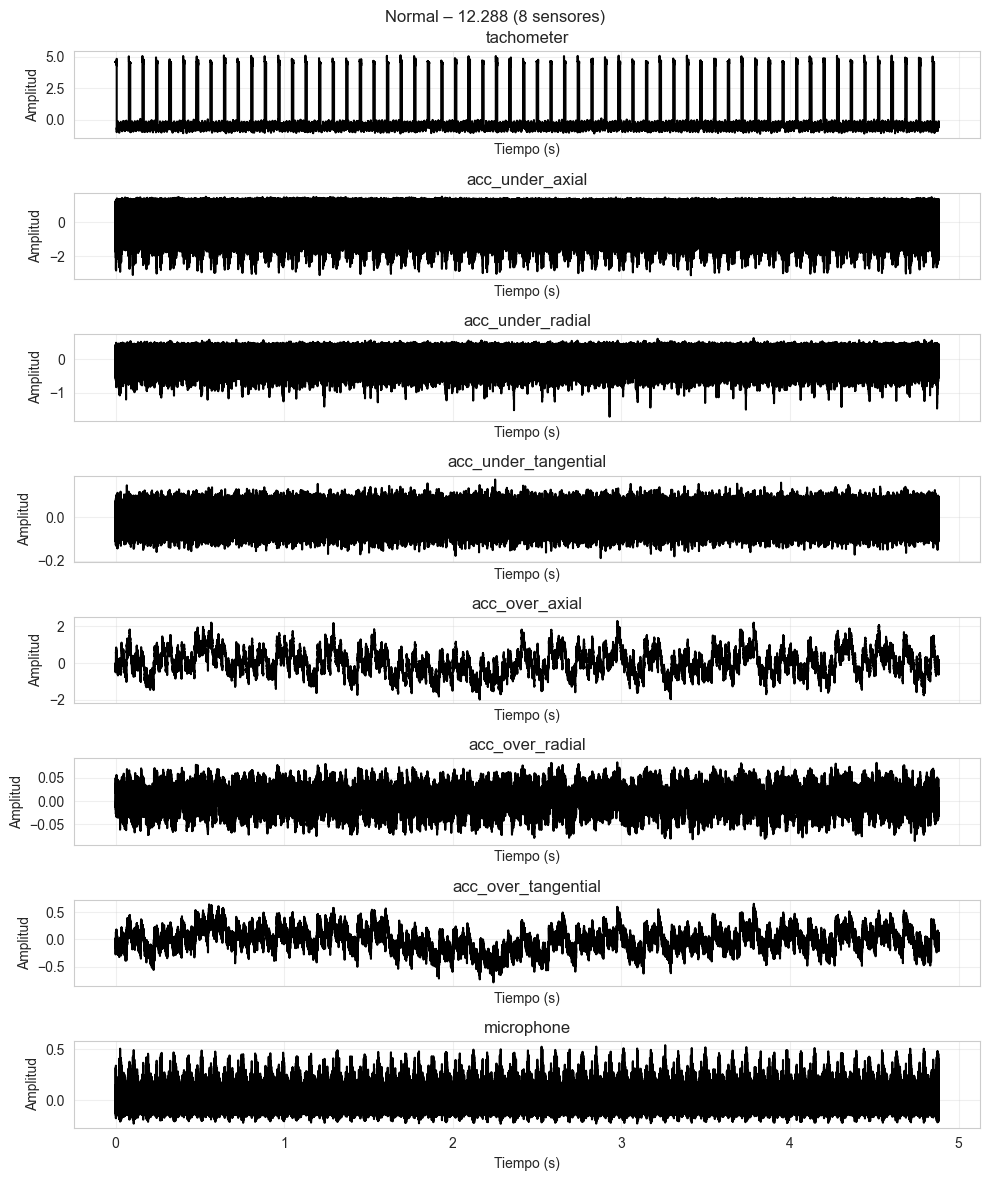

In [47]:
fs=51200

temporal = np.arange(len(normal_12288))/fs

# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(normal_12288.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, normal_12288.columns):
    run_sequence_plot(
        temporal,
        normal_12288[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Normal – 12.288 (8 sensores)")
plt.tight_layout()
plt.show()

# Horizontal misaligment:

In [48]:
# Cargar CSV SIN header y asignar nombres
hor_misalig_05 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced" / "horizontal-misalignment" / "0.5mm" / "12.288.csv",
    header=None,
    names=sensor_names)

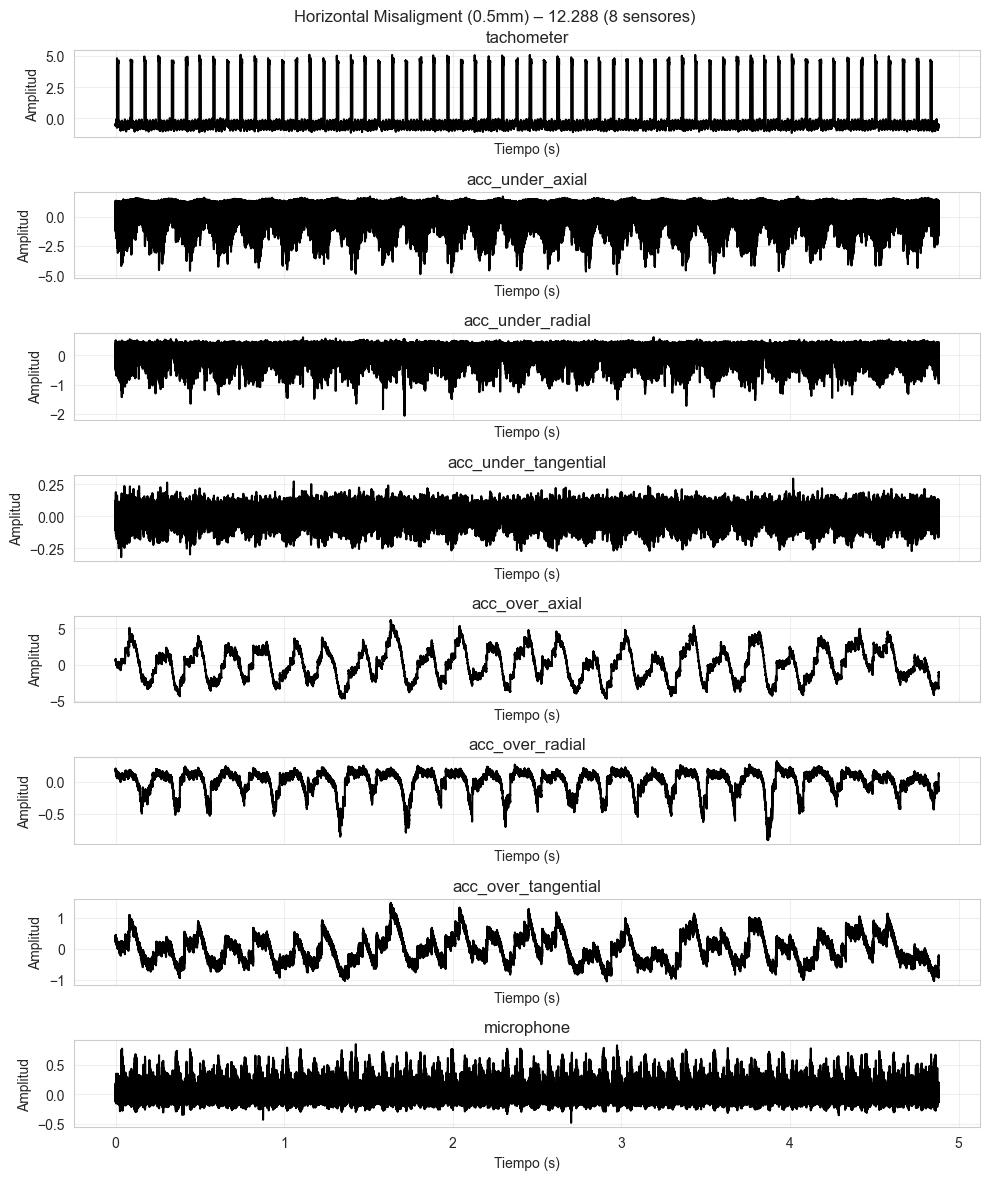

In [9]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(hor_misalig_05.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, hor_misalig_05.columns):
    run_sequence_plot(
        temporal,
        hor_misalig_05[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Horizontal Misaligment (0.5mm) – 12.288 (8 sensores)")
plt.tight_layout()
plt.show()

## Compación normal vs horizontal misaligment

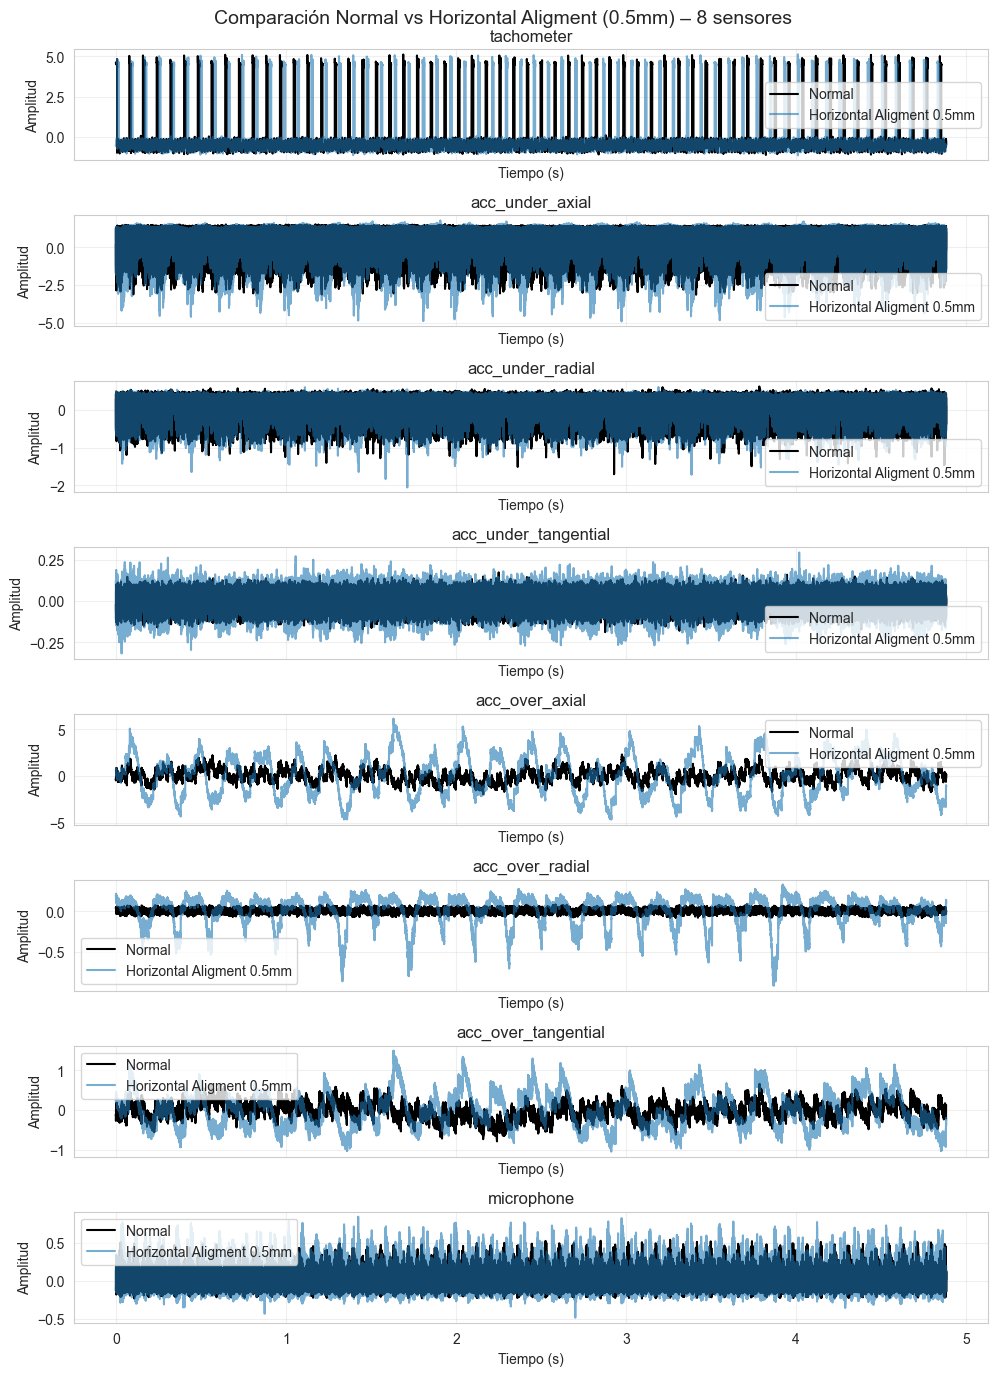

In [10]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        hor_misalig_05[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Horizontal Aligment 0.5mm"])

fig.suptitle("Comparación Normal vs Horizontal Aligment (0.5mm) – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
signals_by_condition = {
    "normal": normal_12288,
    "horizontal_0.5": hor_misalig_05
}

In [12]:
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():

        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)
df_features

mean       std       rms       max       min       ptp  kurtosis  \
0   0.002930  1.585570  1.585572  5.107800 -1.125900   6.23370  4.304473   
1   0.002844  1.588314  1.588316  5.114900 -1.150800   6.26570  4.261619   
2  -0.002661  0.979174  0.979178  1.528400 -3.142900   4.67130 -1.065732   
3   0.010533  1.114815  1.114865  1.766000 -4.907000   6.67300 -0.203988   
4  -0.000632  0.307370  0.307371  0.624310 -1.709000   2.33331 -0.725945   
5   0.002472  0.305721  0.305731  0.610280 -2.061900   2.67218 -0.174034   
6   0.000324  0.044809  0.044810  0.173330 -0.188460   0.36179 -0.377439   
7   0.002127  0.058942  0.058981  0.293430 -0.317730   0.61116  0.295870   
8   0.031088  0.668105  0.668827  2.280100 -1.976300   4.25640 -0.387141   
9   0.040626  2.124300  2.124689  6.124400 -4.681700  10.80610 -0.848509   
10  0.003156  0.030200  0.030364  0.082952 -0.085668   0.16862 -0.767459   
11  0.004085  0.183408  0.183453  0.324830 -0.914280   1.23911  2.246780   
12  0.004970  0.197512  0.197575  0.655470 -0.790590   1.44606 -0.250981   
13  0.002572  0.433117  0.433125  1.489300 -1.048600   2.53790 -0.550439   
14  0.008016  0.112139  0.112425  0.540400 -0.233760   0.77416  0.065309   
15  0.017537  0.144844  0.145901  0.843330 -0.483620   1.32695  0.824592   

    skewness  zero_crossings                sensor       condition  
0   2.500403             145            tachometer          normal  
1   2.492287             144            tachometer  horizontal_0.5  
2  -0.296534          205848       acc_under_axial          normal  
3  -0.724941          177592       acc_under_axial  horizontal_0.5  
4  -0.391702          203768      acc_under_radial          normal  
5  -0.680915          182886      acc_under_radial  horizontal_0.5  
6  -0.218167          150440  acc_under_tangential          normal  
7  -0.397348          111507  acc_under_tangential  horizontal_0.5  
8   0.163729            8639        acc_over_axial          normal  
9   0.057190            2653        acc_over_axial  horizontal_0.5  
10 -0.093602            9816       acc_over_radial          normal  
11 -1.506912            1480       acc_over_radial  horizontal_0.5  
12 -0.051334           27055   acc_over_tangential          normal  
13  0.311357           10587   acc_over_tangential  horizontal_0.5  
14  0.685550          199435            microphone          normal  
15  0.932547          186449            microphone  horizontal_0.5

In [13]:
features = [
    "mean",
    "std",
    "rms",
    "max",
    "min",
    "ptp",
    "kurtosis",
    "skewness",
    "zero_crossings"
]

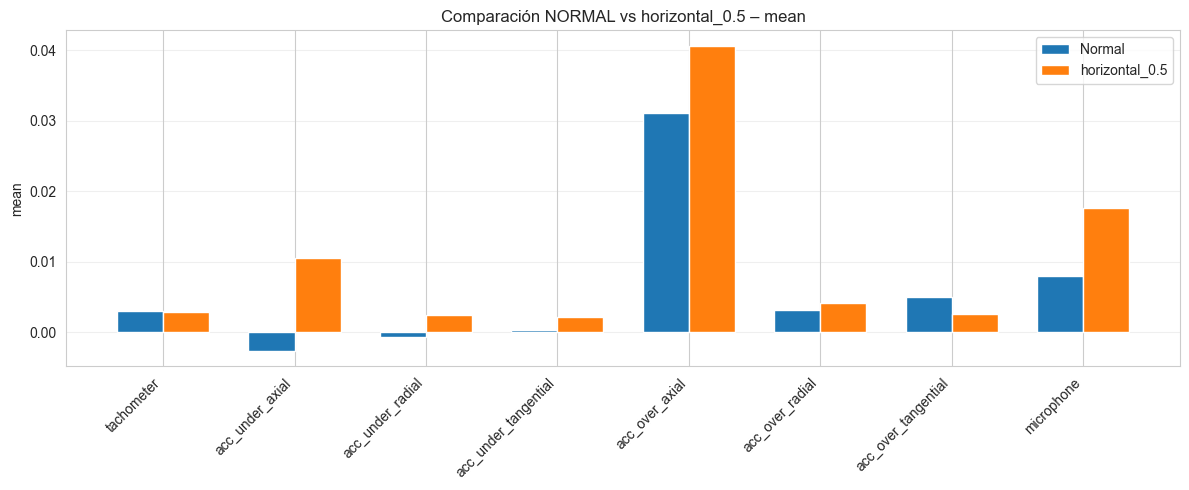

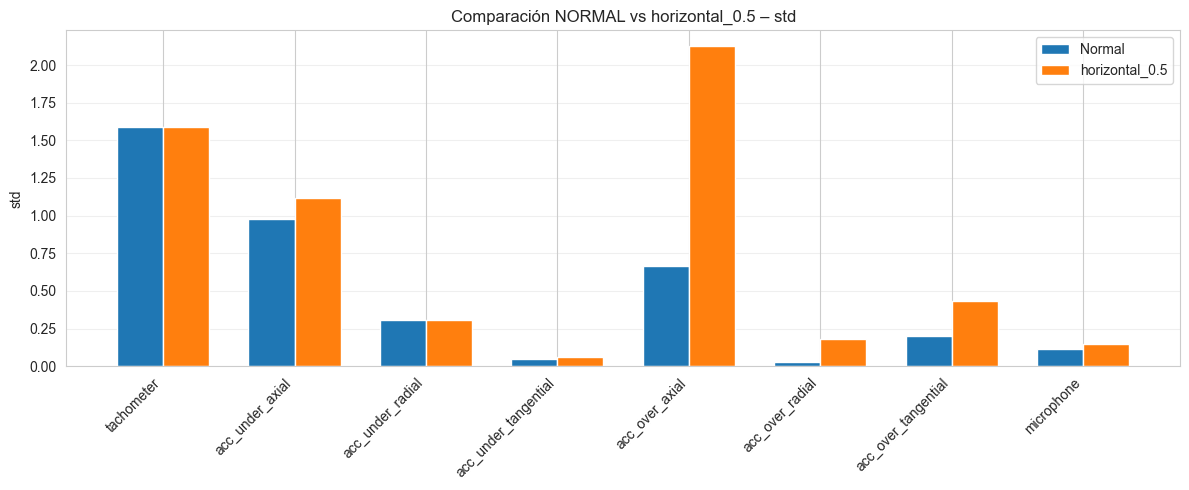

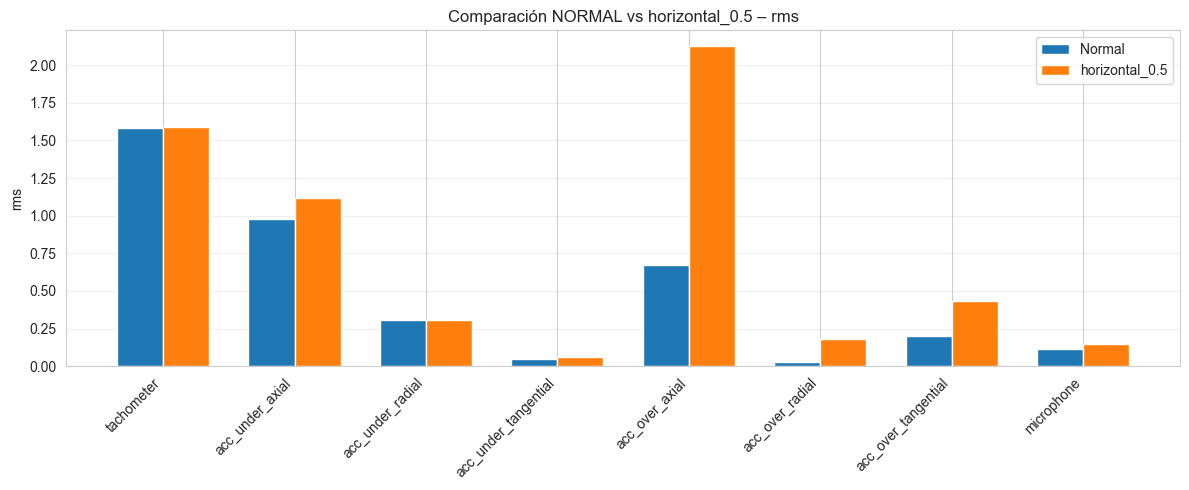

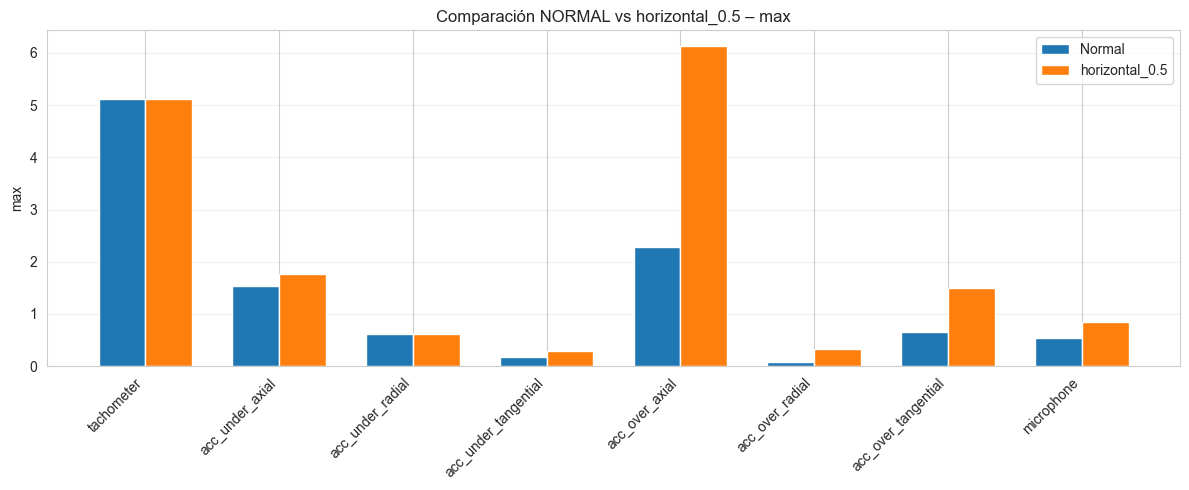

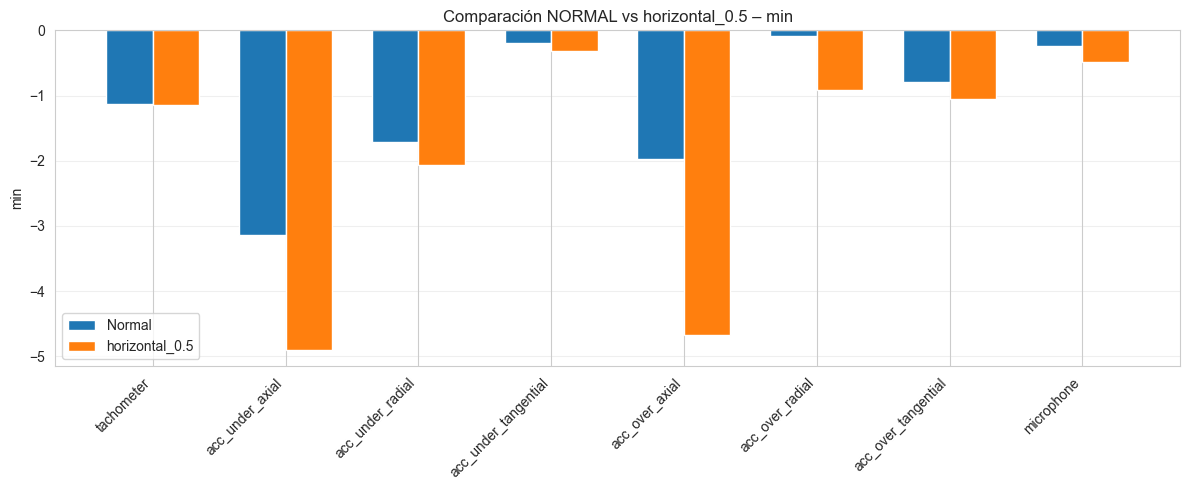

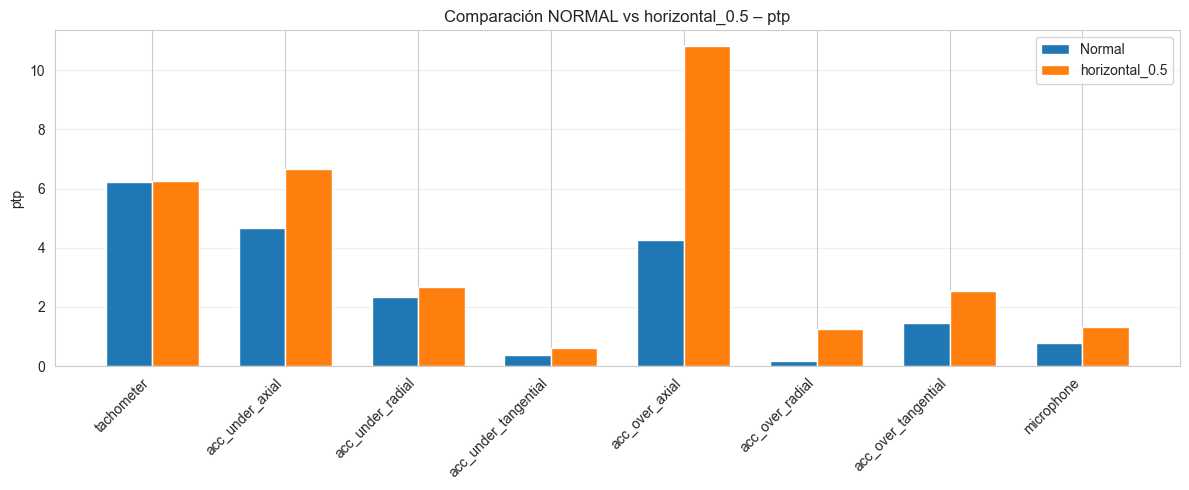

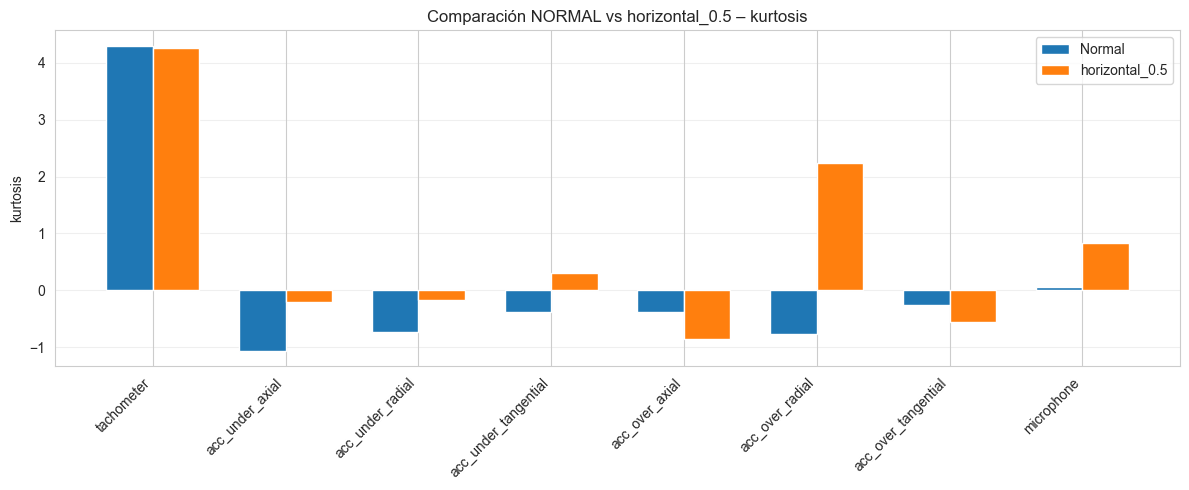

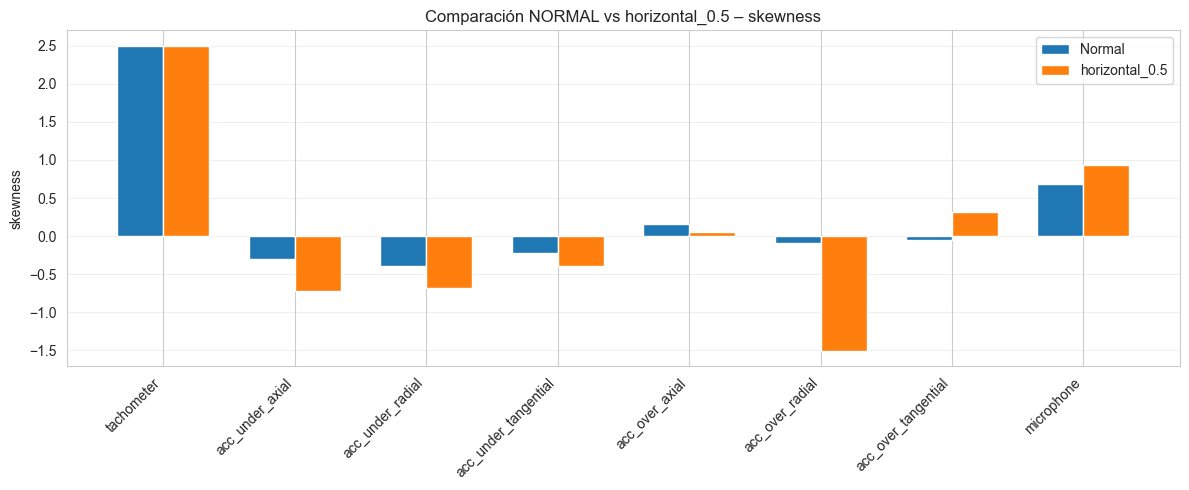

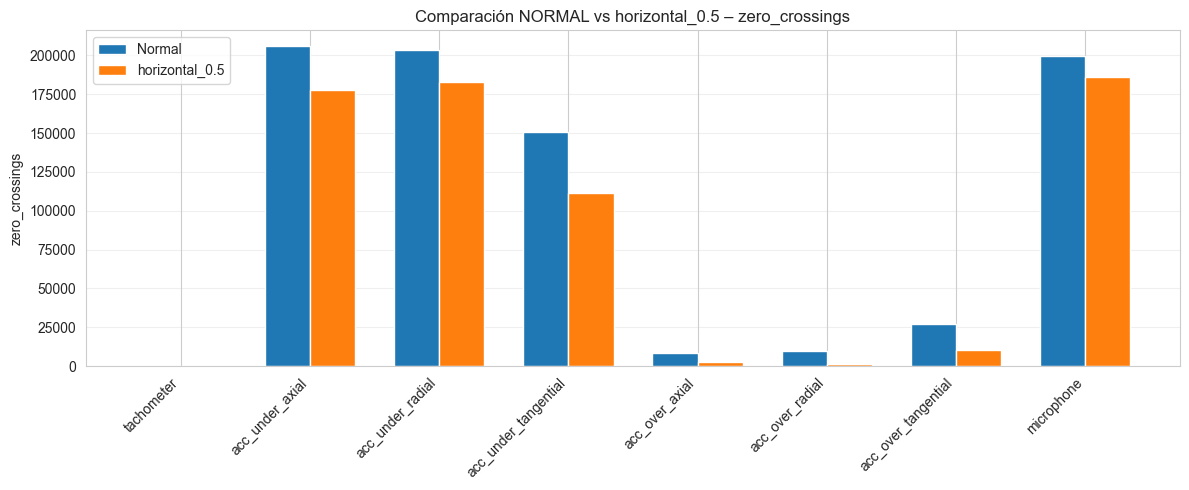

In [14]:
for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["horizontal_0.5", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12,5))

    plt.bar(x - width/2, normal_vals, width, label="Normal")
    plt.bar(x + width/2, imbalance_vals, width, label="horizontal_0.5")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs horizontal_0.5 – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [19]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="horizontal_0.5"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.013193270359454792

Característica: std
Sensor con mayor incremento: acc_over_axial
Incremento: 1.4561958863047324

Característica: rms
Sensor con mayor incremento: acc_over_axial
Incremento: 1.455861437523299

Característica: max
Sensor con mayor incremento: acc_over_axial
Incremento: 3.8442999999999996

Característica: min
Sensor con mayor incremento: tachometer
Incremento: -0.024900000000000144

Característica: ptp
Sensor con mayor incremento: acc_over_axial
Incremento: 6.5497000000000005

Característica: kurtosis
Sensor con mayor incremento: acc_over_radial
Incremento: 3.014239069231305

Característica: skewness
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.3626915221771658

Característica: zero_crossings
Sensor con mayor incremento: tachometer
Incremento: -1



# Vertical misaligment

In [49]:
# Cargar CSV SIN header y asignar nombres
ver_misalig_051 = pd.read_csv(
    PATH / "bearing_fault_detection_reduced" / "vertical-misalignment" / "0.51mm" / "12.4928.csv",
    header=None,
    names=sensor_names)

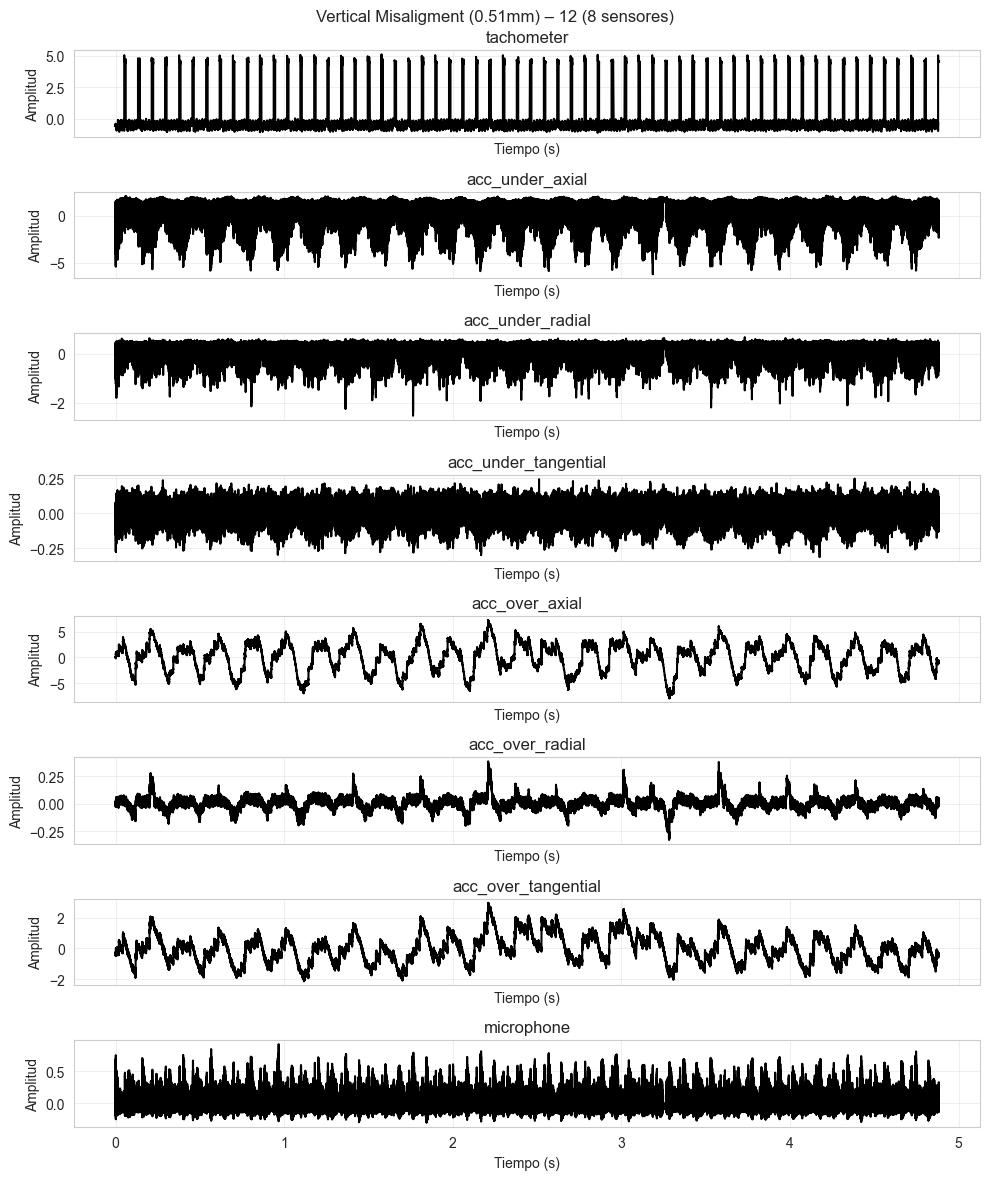

In [21]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(ver_misalig_051.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, ver_misalig_051.columns):
    run_sequence_plot(
        temporal,
        ver_misalig_051[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Vertical Misaligment (0.51mm) – 12 (8 sensores)")
plt.tight_layout()
plt.show()

## Compación normal vs vertical misaligment

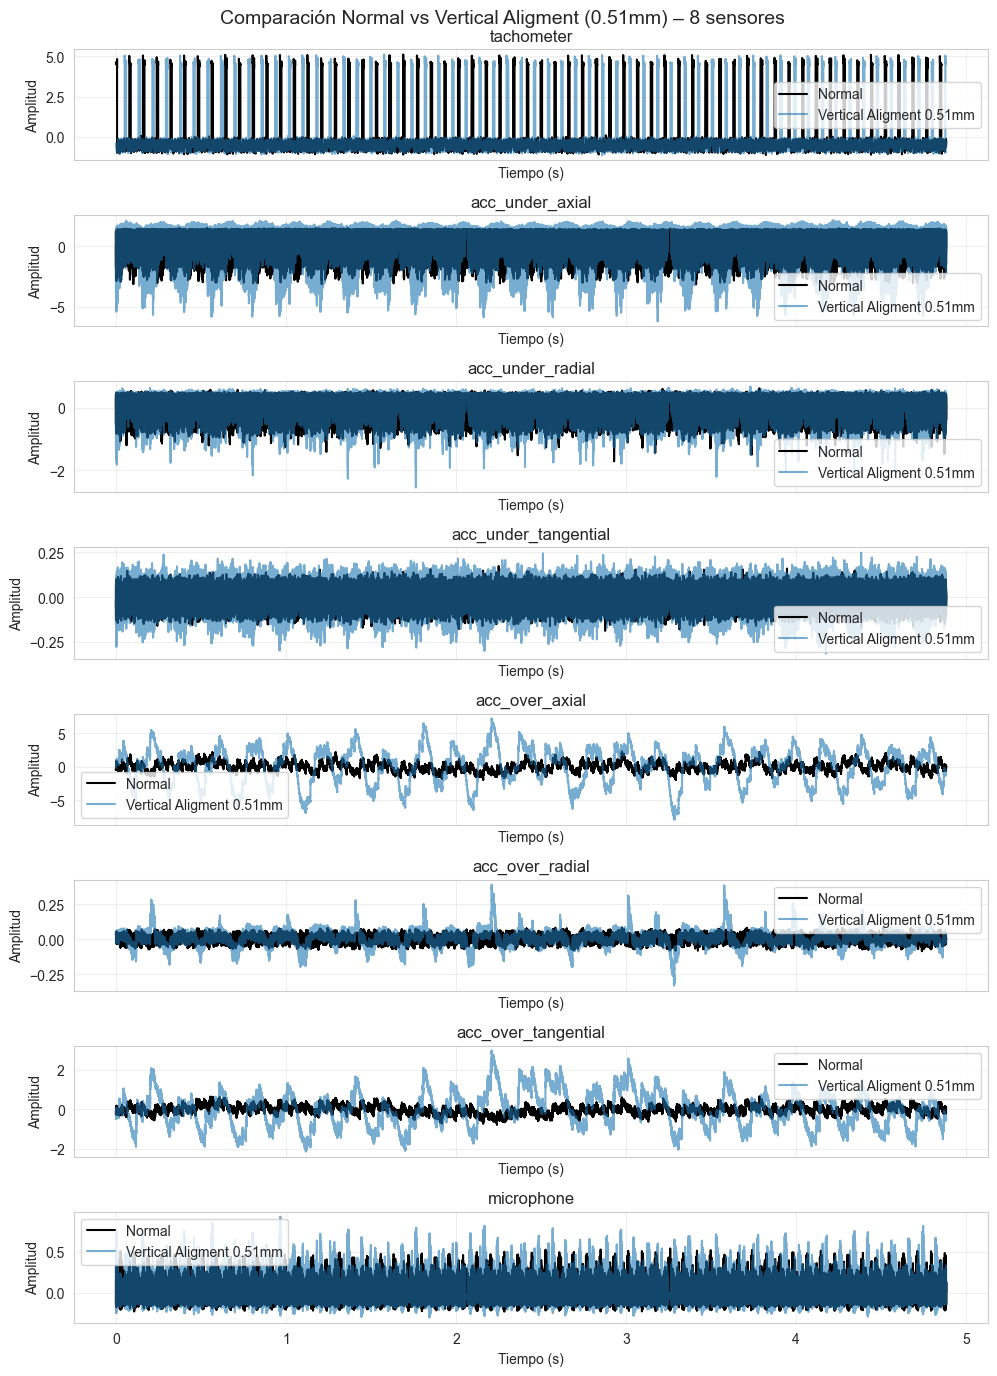

In [22]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        ver_misalig_051[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Vertical Aligment 0.51mm"])

fig.suptitle("Comparación Normal vs Vertical Aligment (0.51mm) – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

In [23]:
signals_by_condition = {
    "normal": normal_12288,
    "vertical_0.51": ver_misalig_051
}

In [24]:
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():

        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)
df_features

mean       std       rms       max       min       ptp  kurtosis  \
0   0.002930  1.585570  1.585572  5.107800 -1.125900   6.23370  4.304473   
1  -0.001608  1.583158  1.583159  5.114900 -1.148300   6.26320  4.333908   
2  -0.002661  0.979174  0.979178  1.528400 -3.142900   4.67130 -1.065732   
3   0.025476  1.428717  1.428944  2.150400 -6.210200   8.36060 -0.056997   
4  -0.000632  0.307370  0.307371  0.624310 -1.709000   2.33331 -0.725945   
5   0.001568  0.359941  0.359944  0.680110 -2.541600   3.22171  0.007723   
6   0.000324  0.044809  0.044810  0.173330 -0.188460   0.36179 -0.377439   
7   0.001002  0.060904  0.060912  0.248670 -0.315160   0.56383  0.319906   
8   0.031088  0.668105  0.668827  2.280100 -1.976300   4.25640 -0.387141   
9   0.026747  2.716943  2.717075  7.224300 -7.920000  15.14430 -0.642313   
10  0.003156  0.030200  0.030364  0.082952 -0.085668   0.16862 -0.767459   
11  0.006873  0.062392  0.062769  0.387940 -0.329780   0.71772  3.016592   
12  0.004970  0.197512  0.197575  0.655470 -0.790590   1.44606 -0.250981   
13 -0.020129  0.881105  0.881335  2.964600 -2.139000   5.10360 -0.436761   
14  0.008016  0.112139  0.112425  0.540400 -0.233760   0.77416  0.065309   
15  0.020090  0.133510  0.135013  0.928830 -0.307750   1.23658  1.227993   

    skewness  zero_crossings                sensor      condition  
0   2.500403             145            tachometer         normal  
1   2.506404             141            tachometer  vertical_0.51  
2  -0.296534          205848       acc_under_axial         normal  
3  -0.797276          168560       acc_under_axial  vertical_0.51  
4  -0.391702          203768      acc_under_radial         normal  
5  -0.729686          180347      acc_under_radial  vertical_0.51  
6  -0.218167          150440  acc_under_tangential         normal  
7  -0.382590          106344  acc_under_tangential  vertical_0.51  
8   0.163729            8639        acc_over_axial         normal  
9  -0.332014            1385        acc_over_axial  vertical_0.51  
10 -0.093602            9816       acc_over_radial         normal  
11  0.230237            6249       acc_over_radial  vertical_0.51  
12 -0.051334           27055   acc_over_tangential         normal  
13  0.182456            7826   acc_over_tangential  vertical_0.51  
14  0.685550          199435            microphone         normal  
15  0.992565          191250            microphone  vertical_0.51

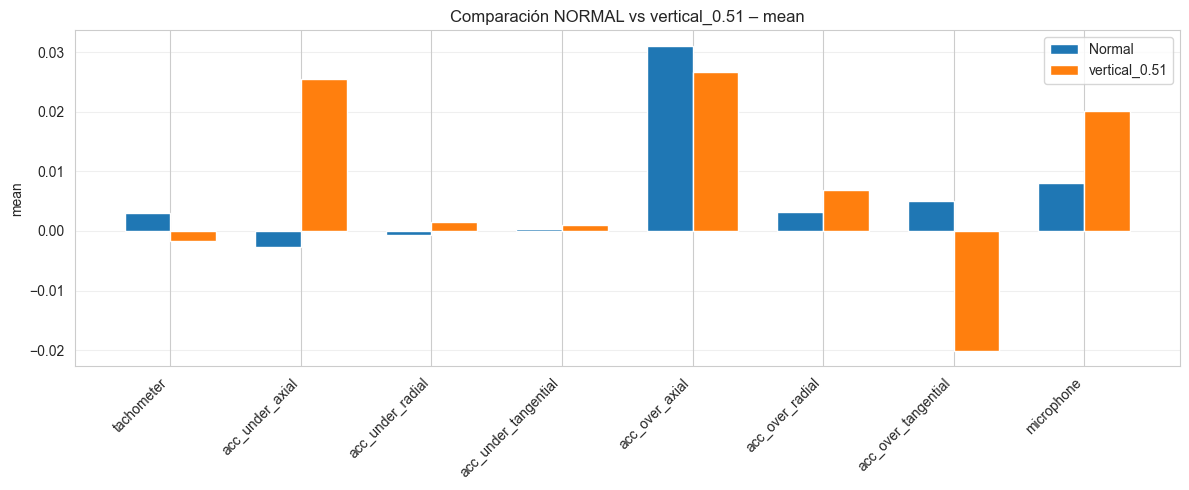

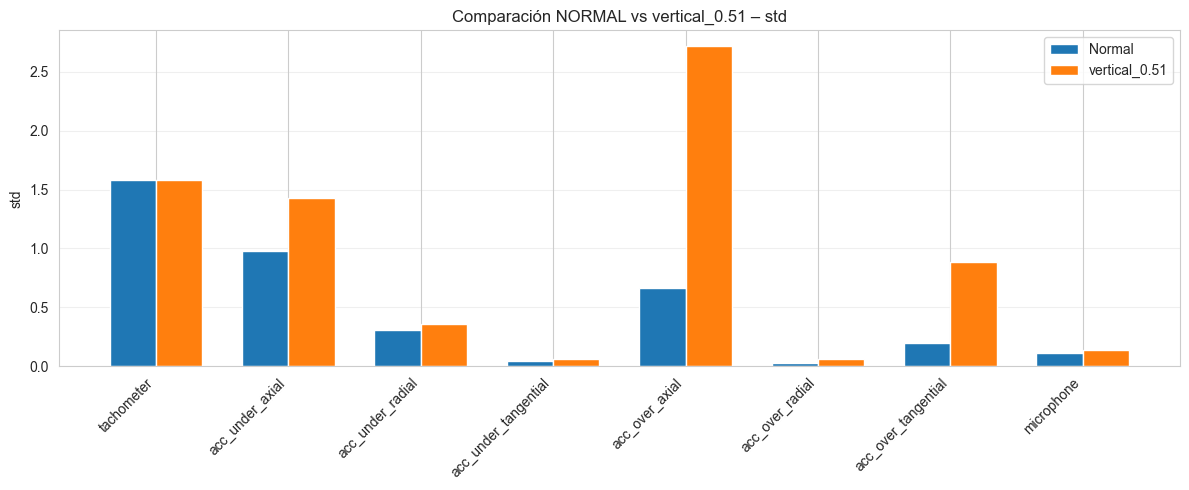

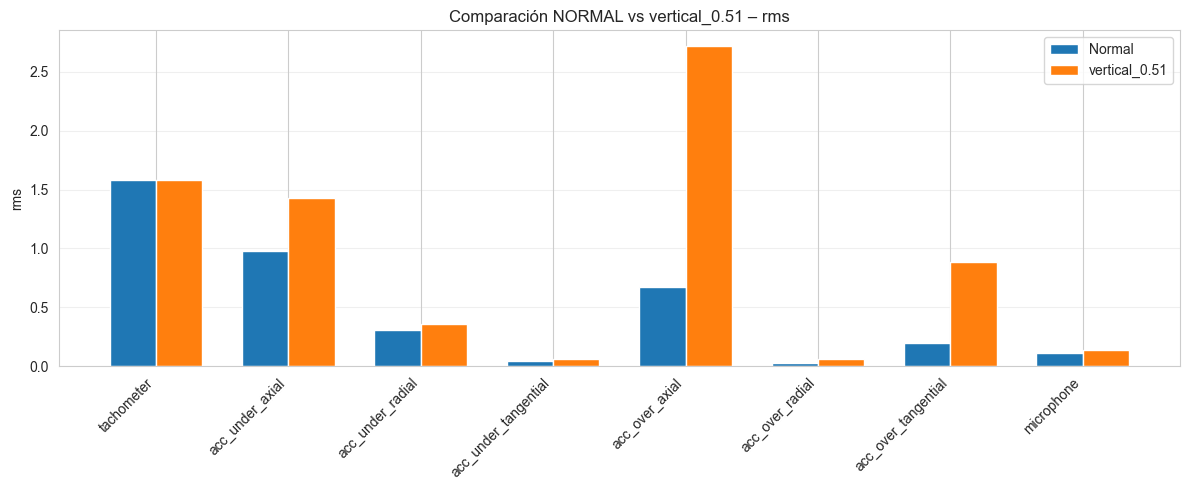

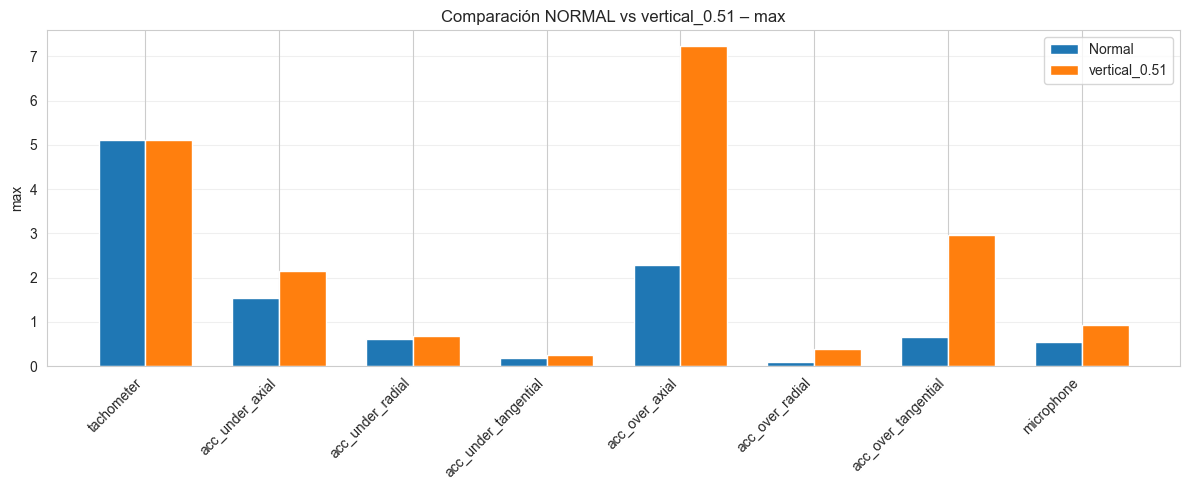

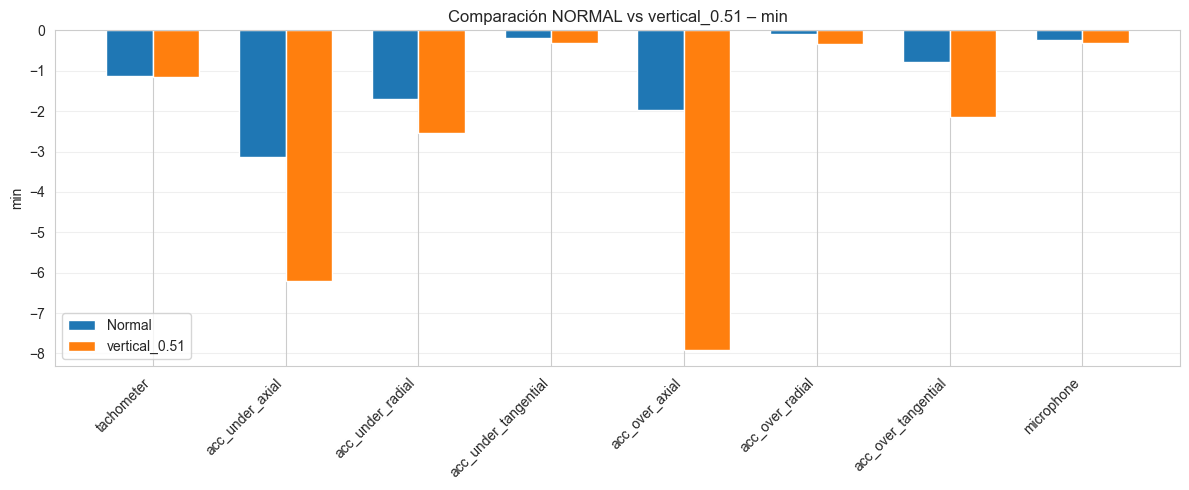

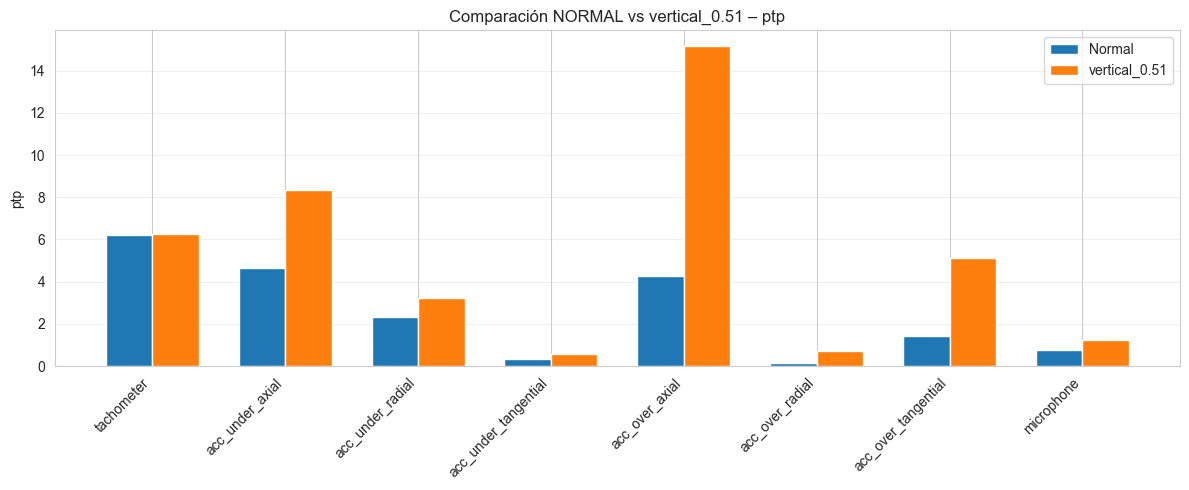

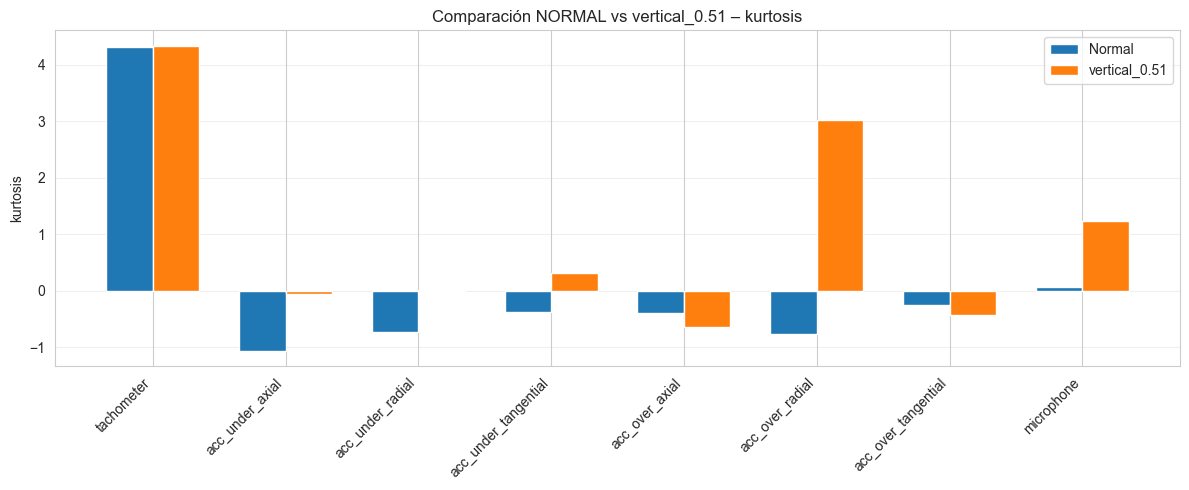

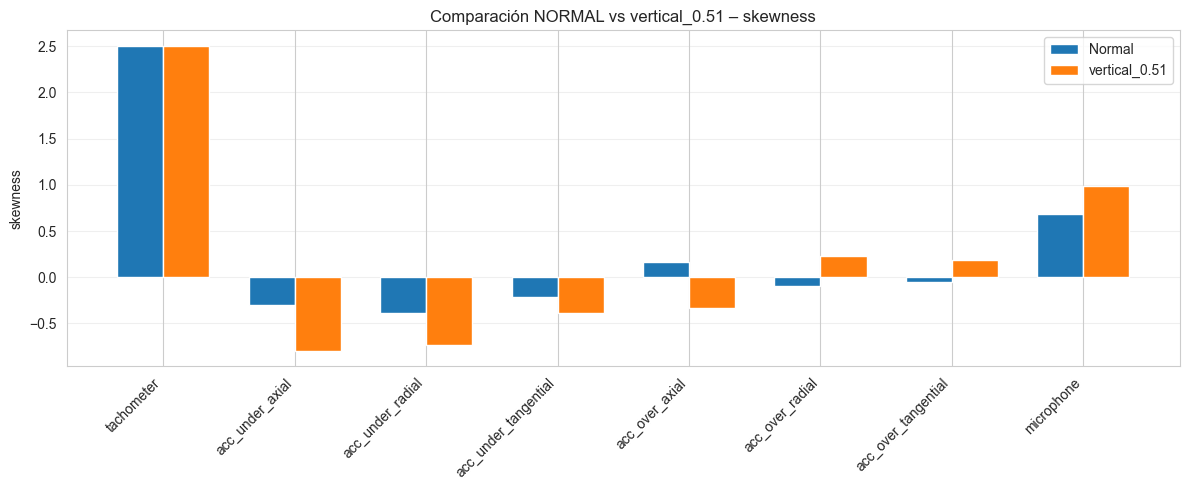

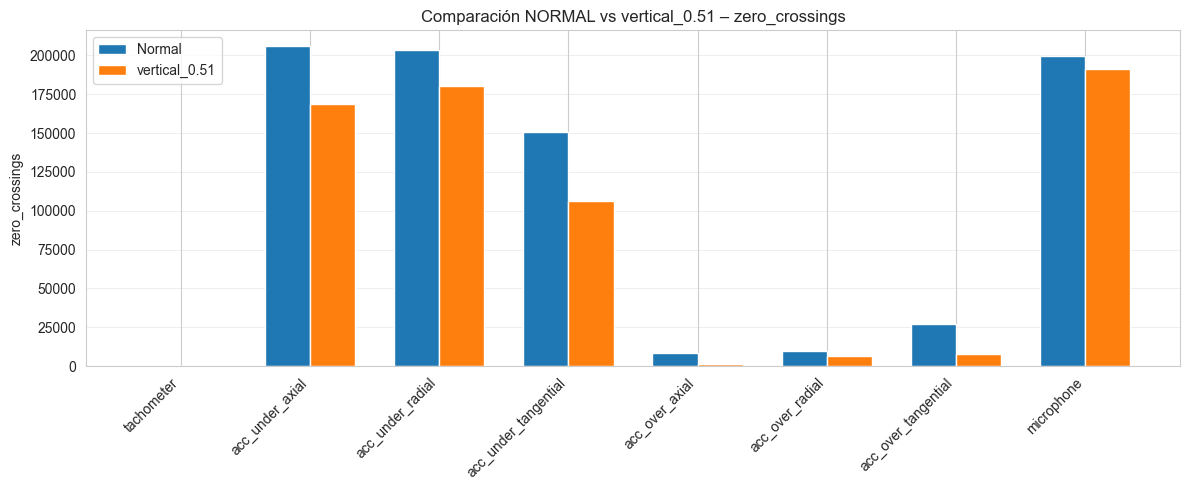

In [25]:
for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["vertical_0.51", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12,5))

    plt.bar(x - width/2, normal_vals, width, label="Normal")
    plt.bar(x + width/2, imbalance_vals, width, label="vertical_0.51")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs vertical_0.51 – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [26]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="vertical_0.51"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.028136311251076008

Característica: std
Sensor con mayor incremento: acc_over_axial
Incremento: 2.048838467187176

Característica: rms
Sensor con mayor incremento: acc_over_axial
Incremento: 2.0482472371943237

Característica: max
Sensor con mayor incremento: acc_over_axial
Incremento: 4.9442

Característica: min
Sensor con mayor incremento: tachometer
Incremento: -0.022400000000000198

Característica: ptp
Sensor con mayor incremento: acc_over_axial
Incremento: 10.887900000000002

Característica: kurtosis
Sensor con mayor incremento: acc_over_radial
Incremento: 3.78405139949425

Característica: skewness
Sensor con mayor incremento: acc_over_radial
Incremento: 0.32383859833407186

Característica: zero_crossings
Sensor con mayor incremento: tachometer
Incremento: -4



# Imbalance

In [27]:
# Cargar CSV SIN header y asignar nombres
im_6g_139264 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"imbalance"/"6g" / "13.9264.csv",
    header=None,
    names=sensor_names)

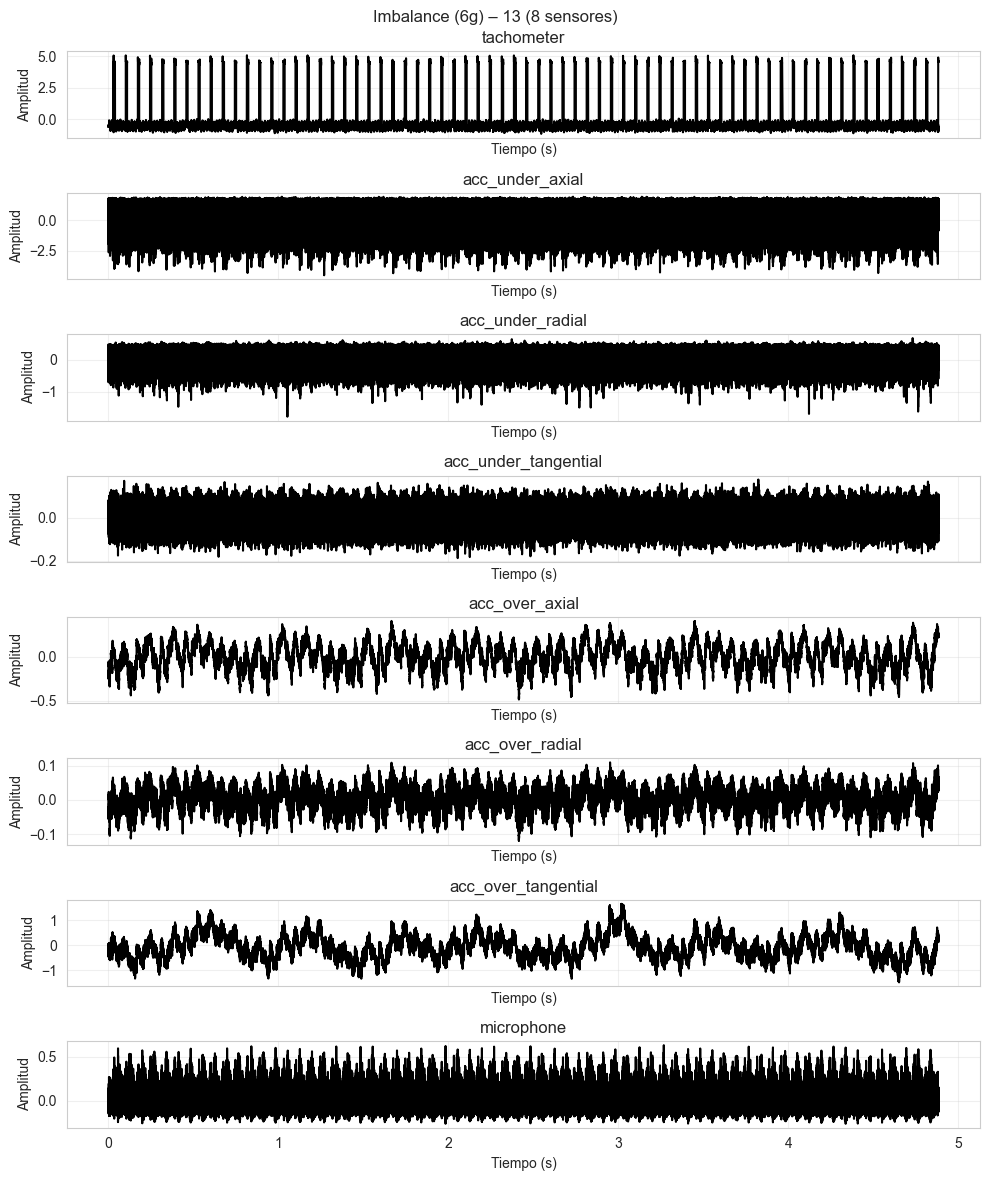

In [28]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(im_6g_139264.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, im_6g_139264.columns):
    run_sequence_plot(
        temporal,
        im_6g_139264[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Imbalance (6g) – 13 (8 sensores)")
plt.tight_layout()
plt.show()

## Comparación normal vs imbalance

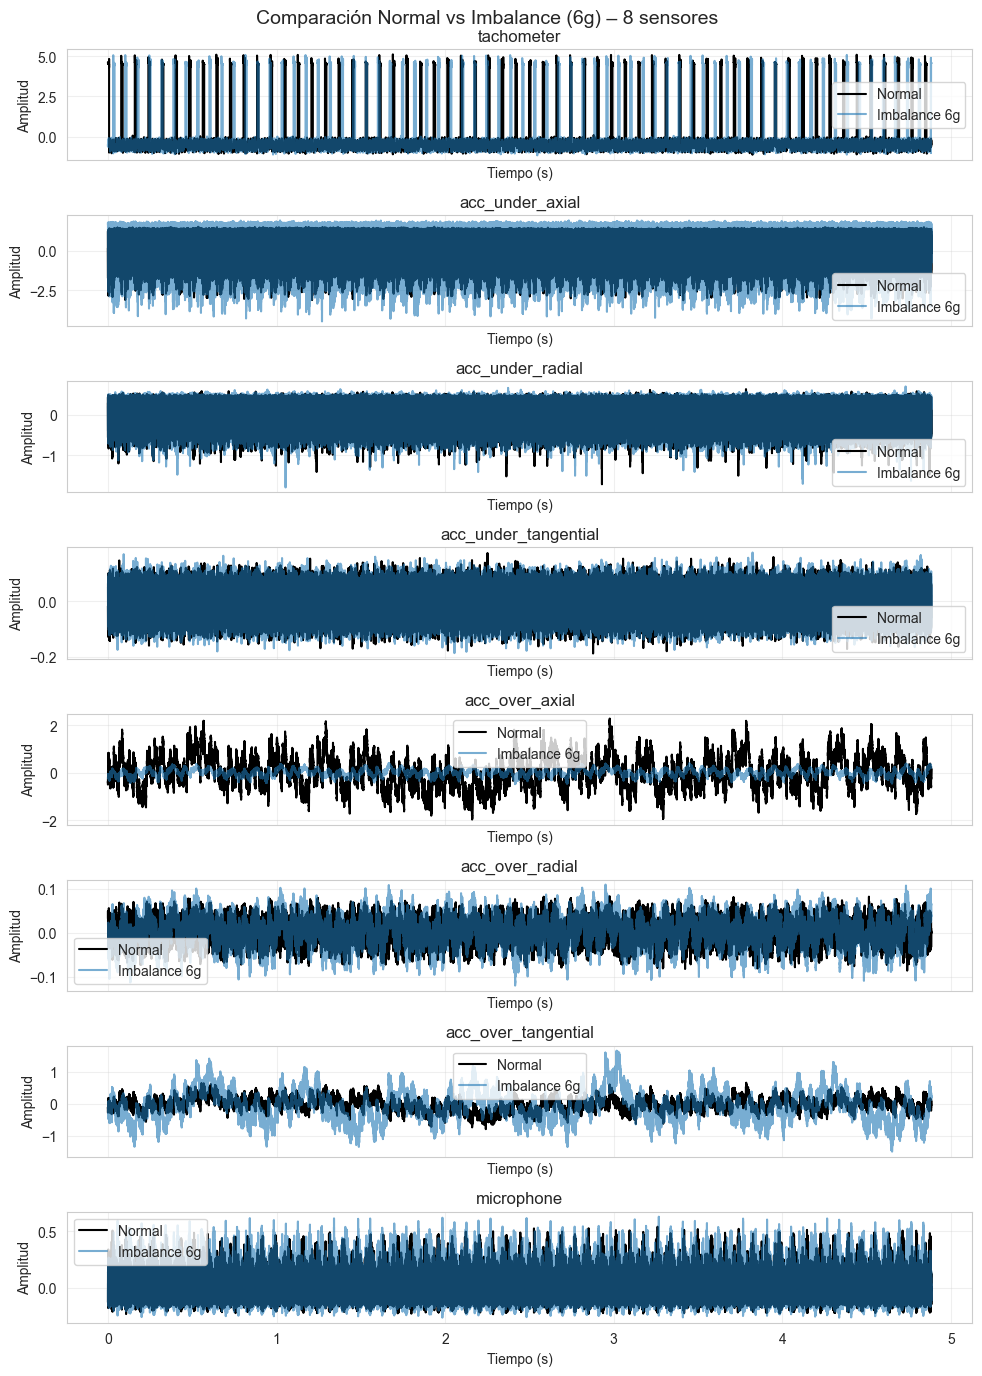

In [29]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        im_6g_139264[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Imbalance 6g"])

fig.suptitle("Comparación Normal vs Imbalance (6g) – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

In [30]:
signals_by_condition = {
    "normal": normal_12288,
    "imbalance_6g": im_6g_139264
}

In [31]:
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():

        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)
df_features

mean       std       rms       max       min      ptp  kurtosis  \
0   0.002930  1.585570  1.585572  5.107800 -1.125900  6.23370  4.304473   
1  -0.001632  1.598095  1.598096  5.072900 -1.165100  6.23800  4.150891   
2  -0.002661  0.979174  0.979178  1.528400 -3.142900  4.67130 -1.065732   
3   0.032769  1.235142  1.235577  1.928600 -4.486100  6.41470 -0.888691   
4  -0.000632  0.307370  0.307371  0.624310 -1.709000  2.33331 -0.725945   
5   0.000674  0.321881  0.321882  0.689570 -1.787000  2.47657 -0.868299   
6   0.000324  0.044809  0.044810  0.173330 -0.188460  0.36179 -0.377439   
7   0.001387  0.046560  0.046580  0.175150 -0.187130  0.36228 -0.316264   
8   0.031088  0.668105  0.668827  2.280100 -1.976300  4.25640 -0.387141   
9   0.001214  0.151328  0.151333  0.406300 -0.485750  0.89205 -0.462879   
10  0.003156  0.030200  0.030364  0.082952 -0.085668  0.16862 -0.767459   
11  0.002236  0.036370  0.036438  0.109210 -0.119560  0.22877 -0.441152   
12  0.004970  0.197512  0.197575  0.655470 -0.790590  1.44606 -0.250981   
13 -0.052413  0.467737  0.470664  1.652700 -1.490000  3.14270 -0.099503   
14  0.008016  0.112139  0.112425  0.540400 -0.233760  0.77416  0.065309   
15  0.016916  0.129080  0.130183  0.629160 -0.264190  0.89335  0.093923   

    skewness  zero_crossings                sensor     condition  
0   2.500403             145            tachometer        normal  
1   2.470234             149            tachometer  imbalance_6g  
2  -0.296534          205848       acc_under_axial        normal  
3  -0.408328          194192       acc_under_axial  imbalance_6g  
4  -0.391702          203768      acc_under_radial        normal  
5  -0.341102          204542      acc_under_radial  imbalance_6g  
6  -0.218167          150440  acc_under_tangential        normal  
7  -0.195604          145826  acc_under_tangential  imbalance_6g  
8   0.163729            8639        acc_over_axial        normal  
9  -0.154212            5053        acc_over_axial  imbalance_6g  
10 -0.093602            9816       acc_over_radial        normal  
11 -0.099142            8185       acc_over_radial  imbalance_6g  
12 -0.051334           27055   acc_over_tangential        normal  
13  0.261190           15425   acc_over_tangential  imbalance_6g  
14  0.685550          199435            microphone        normal  
15  0.713525          198535            microphone  imbalance_6g

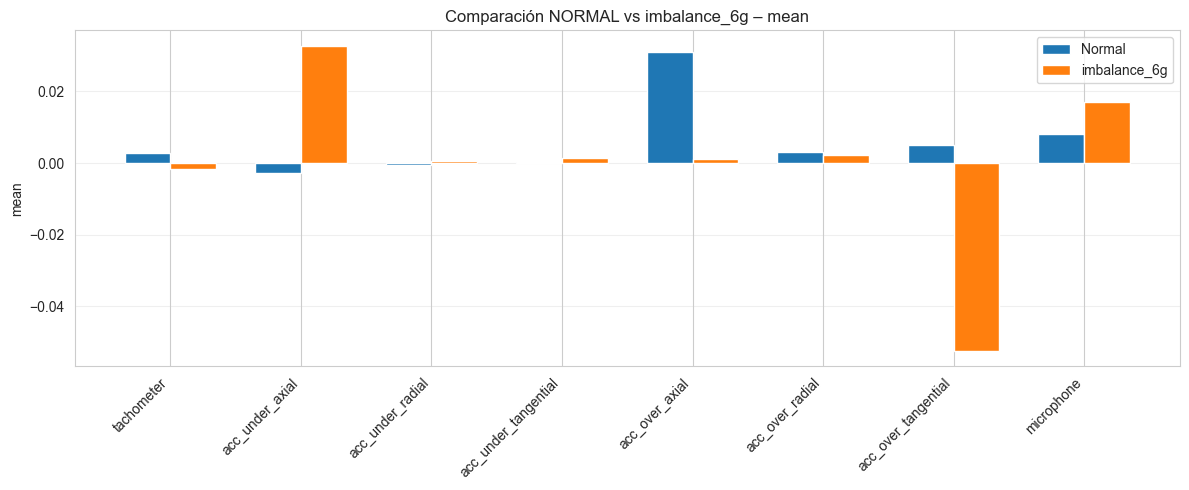

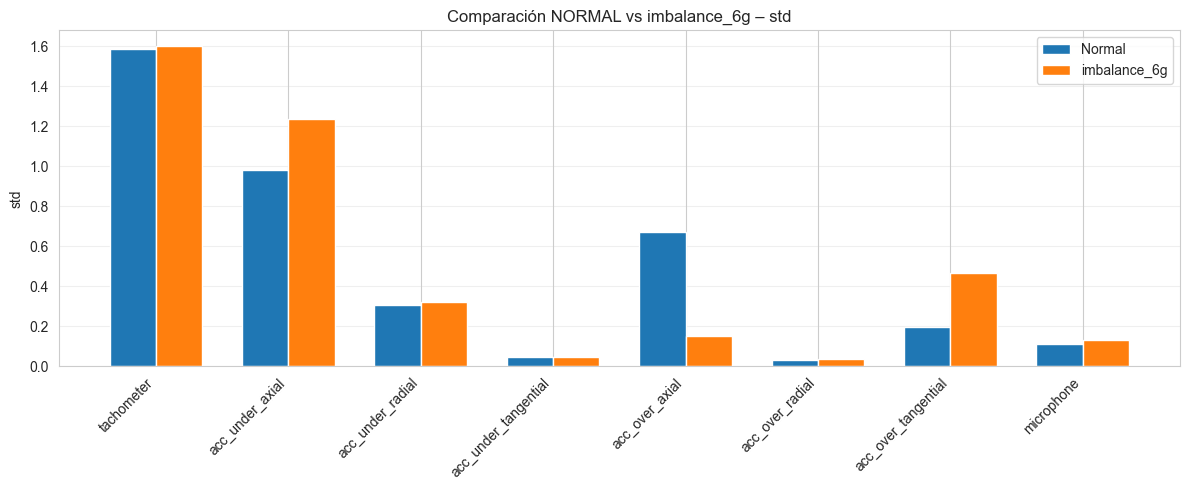

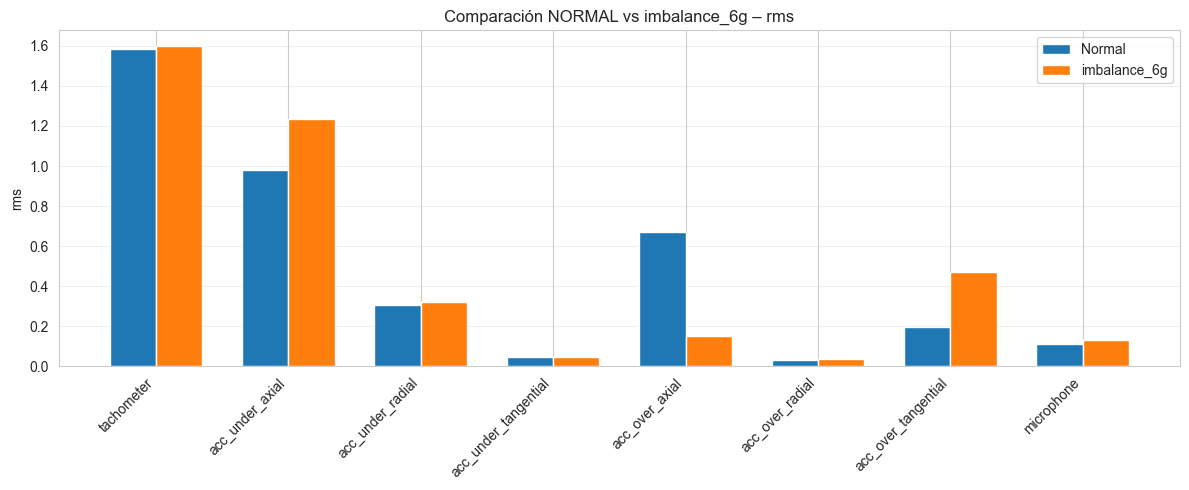

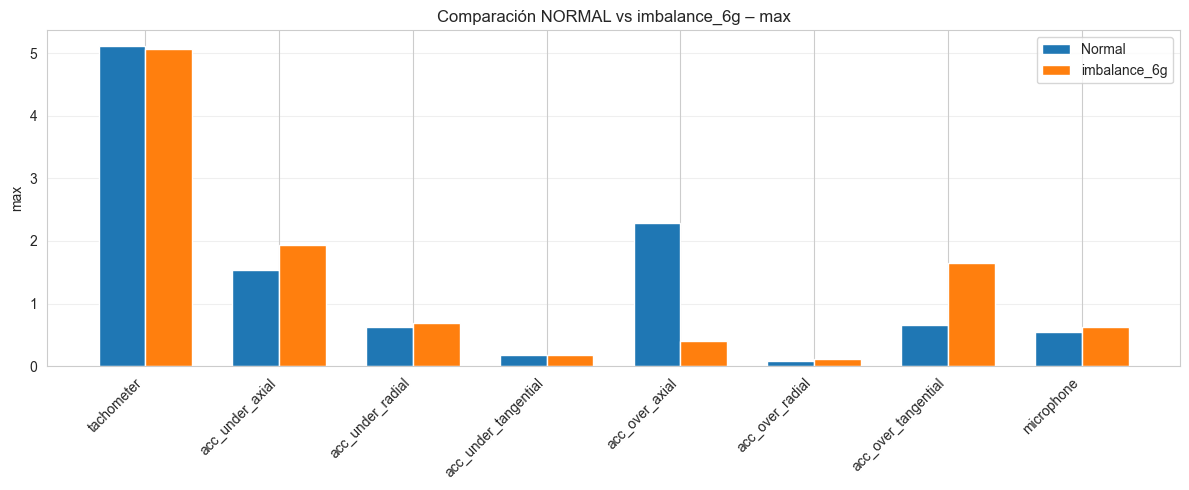

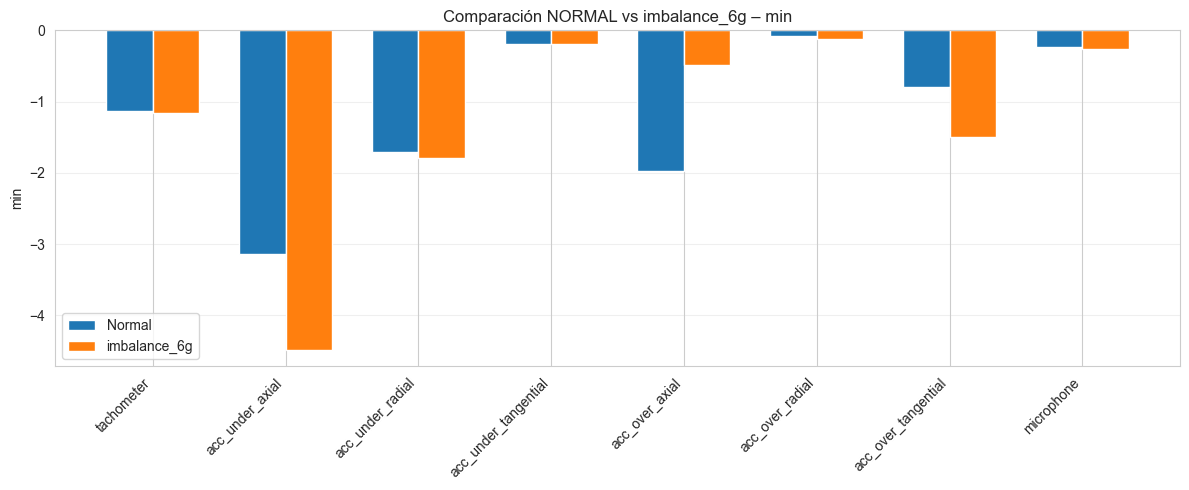

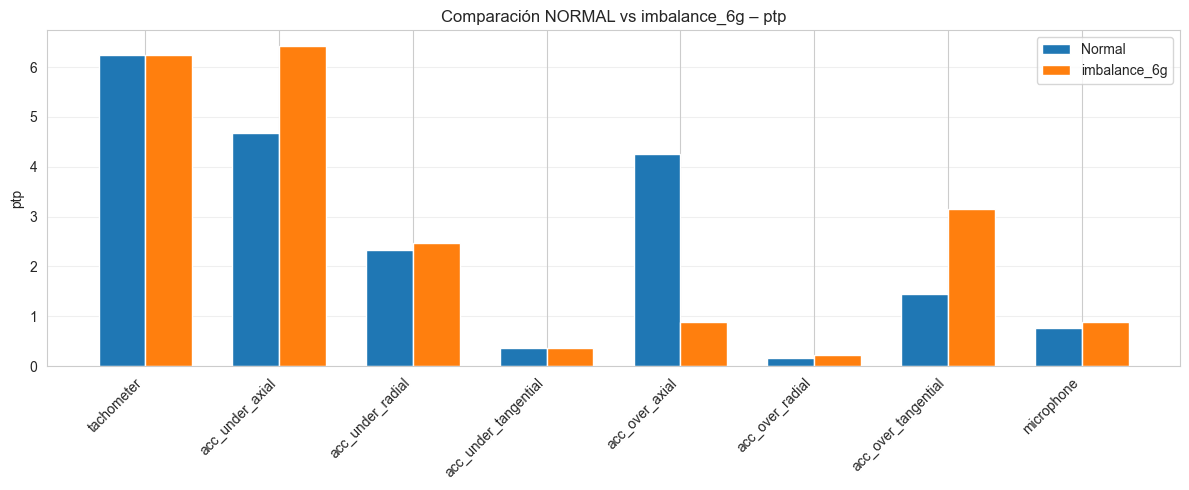

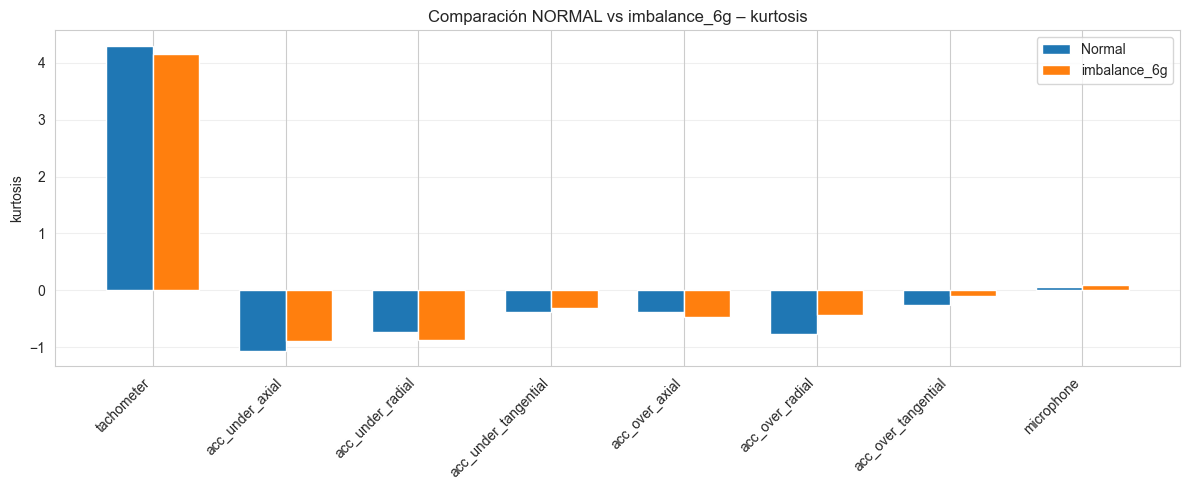

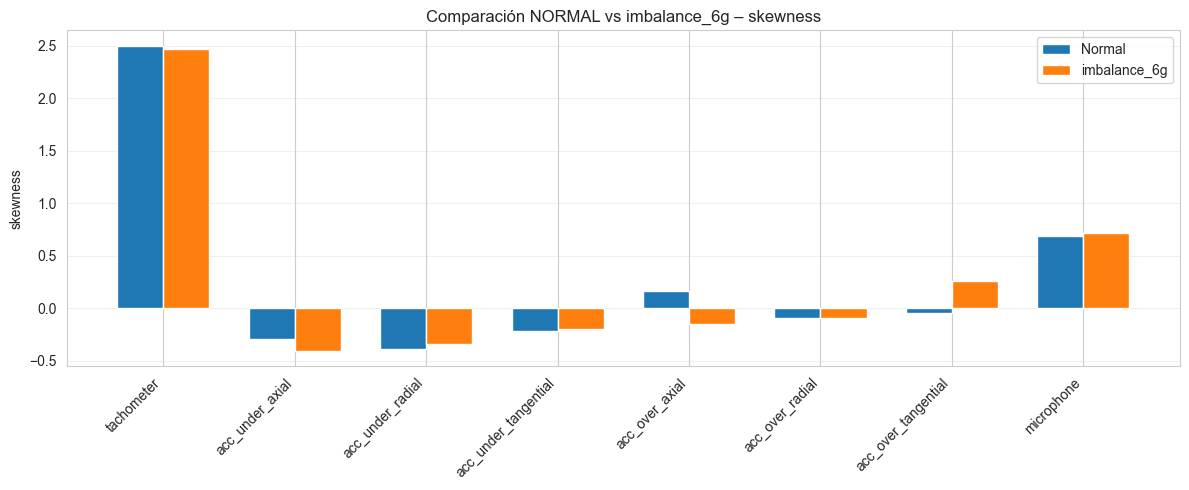

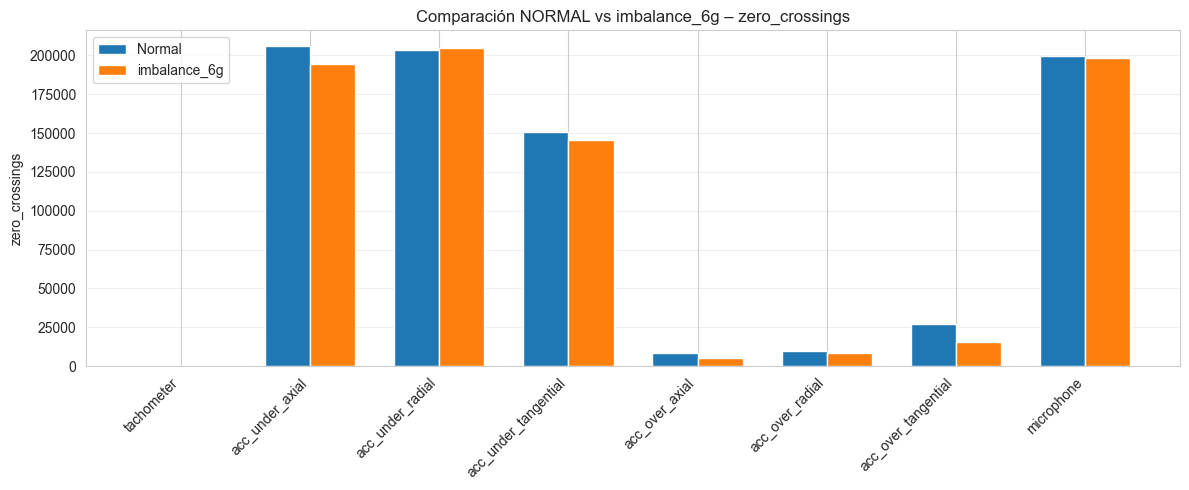

In [32]:
for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["imbalance_6g", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12,5))

    plt.bar(x - width/2, normal_vals, width, label="Normal")
    plt.bar(x + width/2, imbalance_vals, width, label="imbalance_6g")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs imbalance_6g – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [33]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="imbalance_6g"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.03542915126255199

Característica: std
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.27022434080541763

Característica: rms
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.27308925983560783

Característica: max
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.9972300000000001

Característica: min
Sensor con mayor incremento: acc_over_axial
Incremento: 1.4905499999999998

Característica: ptp
Sensor con mayor incremento: acc_under_axial
Incremento: 1.7434000000000003

Característica: kurtosis
Sensor con mayor incremento: acc_over_radial
Incremento: 0.3263074160085182

Característica: skewness
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.3125247383226263

Característica: zero_crossings
Sensor con mayor incremento: acc_under_radial
Incremento: 774



# Overhang

In [34]:
# Cargar CSV SIN header y asignar nombres
ov_bf_0g = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"overhang"/"ball_fault"/"0g"/"12.9024.csv",
    header=None,
    names=sensor_names)

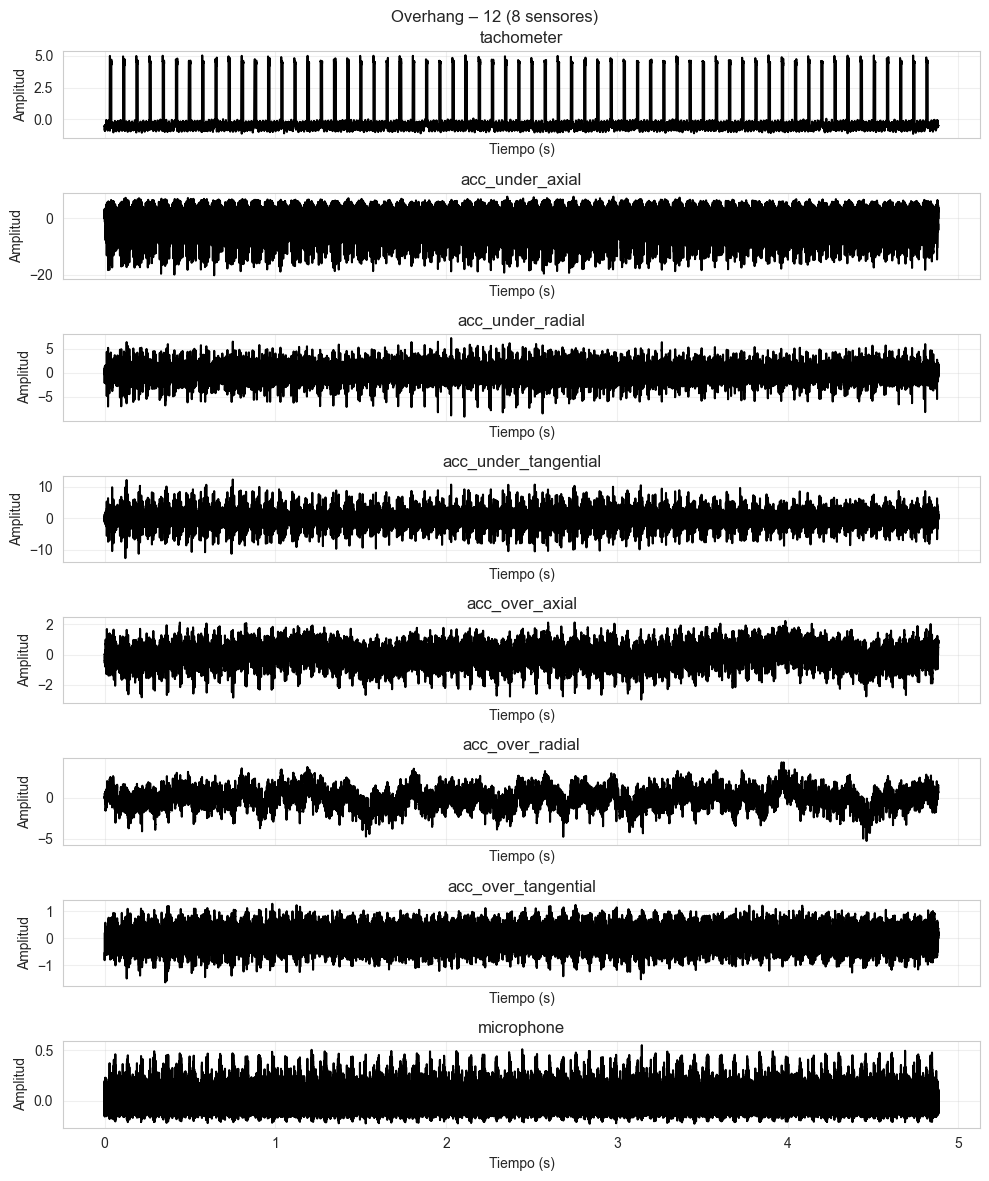

In [35]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(ov_bf_0g.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, ov_bf_0g.columns):
    run_sequence_plot(
        temporal,
        ov_bf_0g[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Overhang – 12 (8 sensores)")
plt.tight_layout()
plt.show()

## Comparación normal vs Overhang

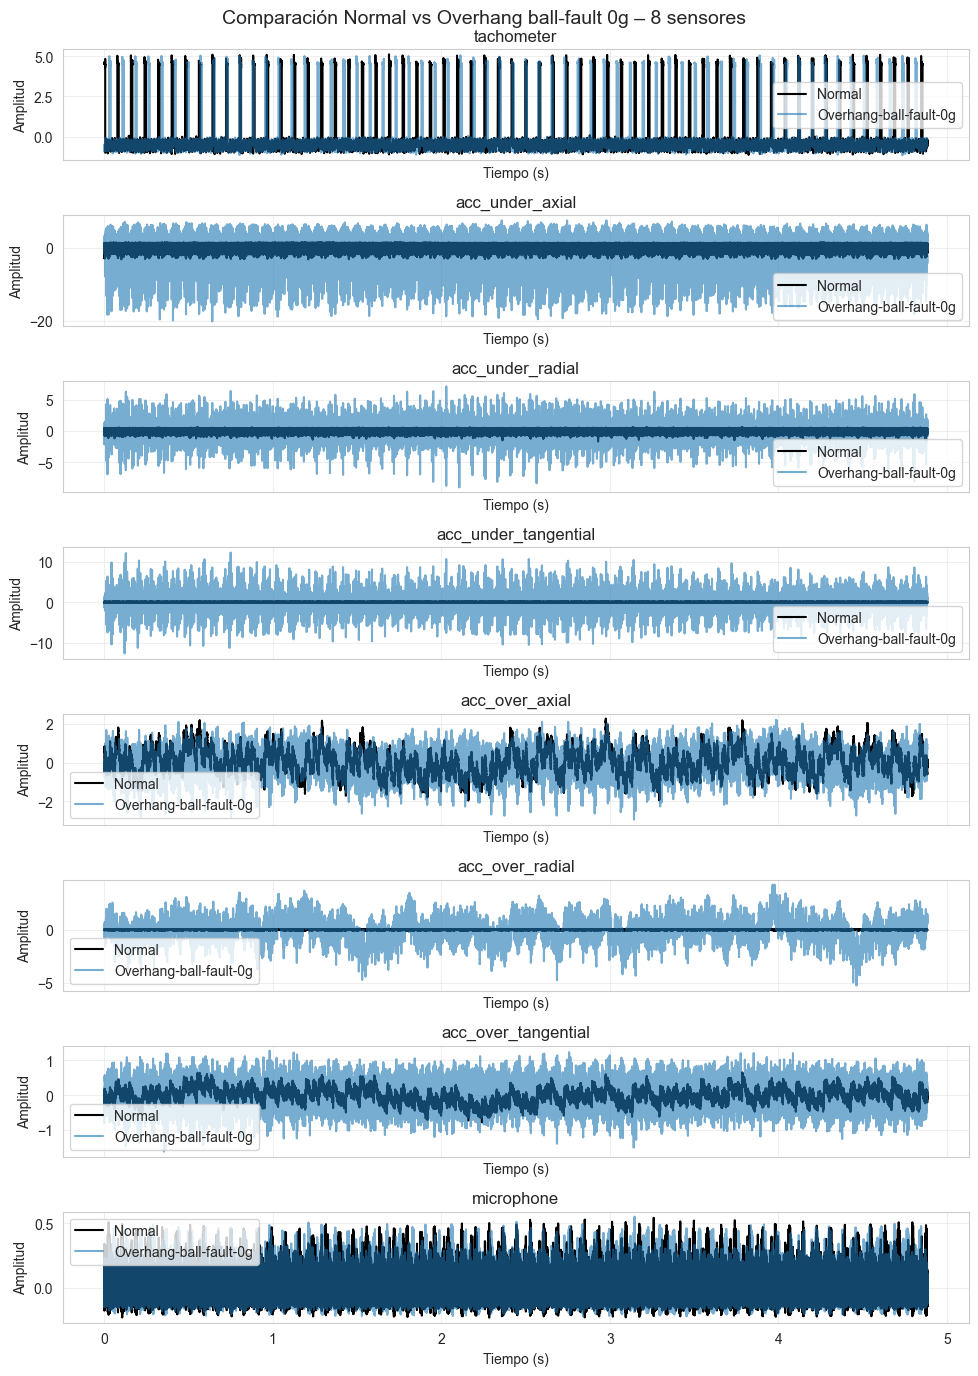

In [36]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        ov_bf_0g[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Overhang-ball-fault-0g"])

fig.suptitle("Comparación Normal vs Overhang ball-fault 0g – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

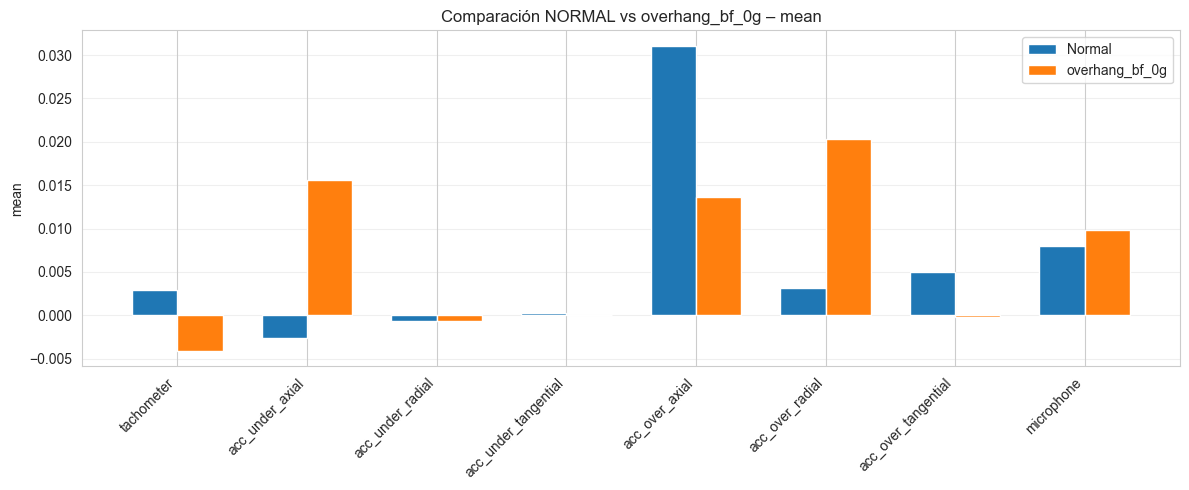

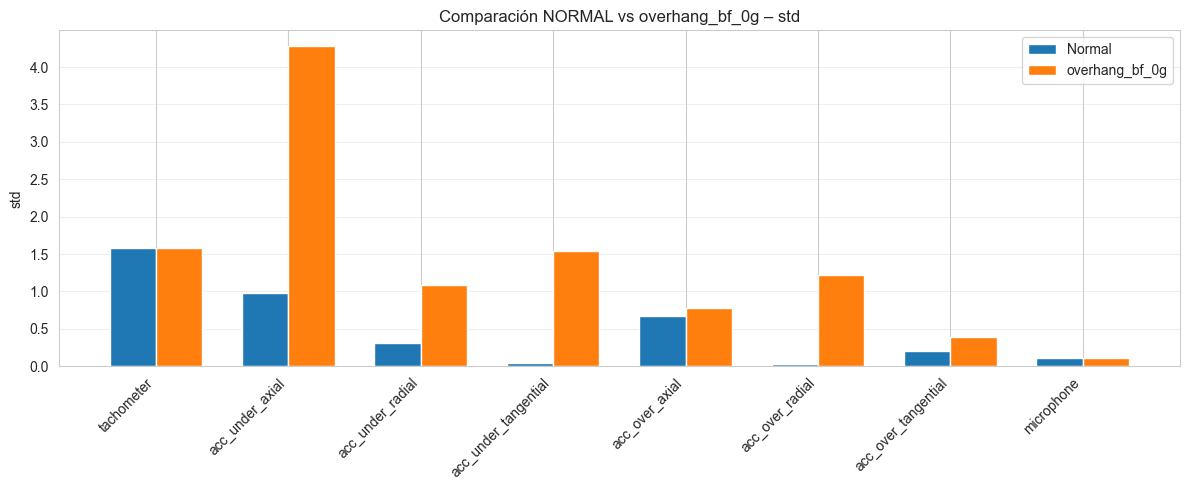

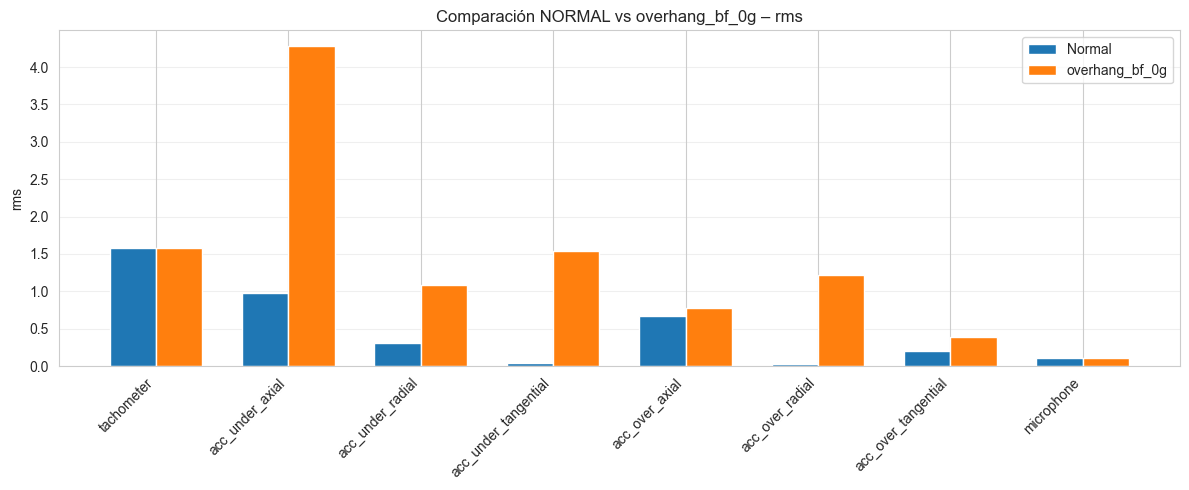

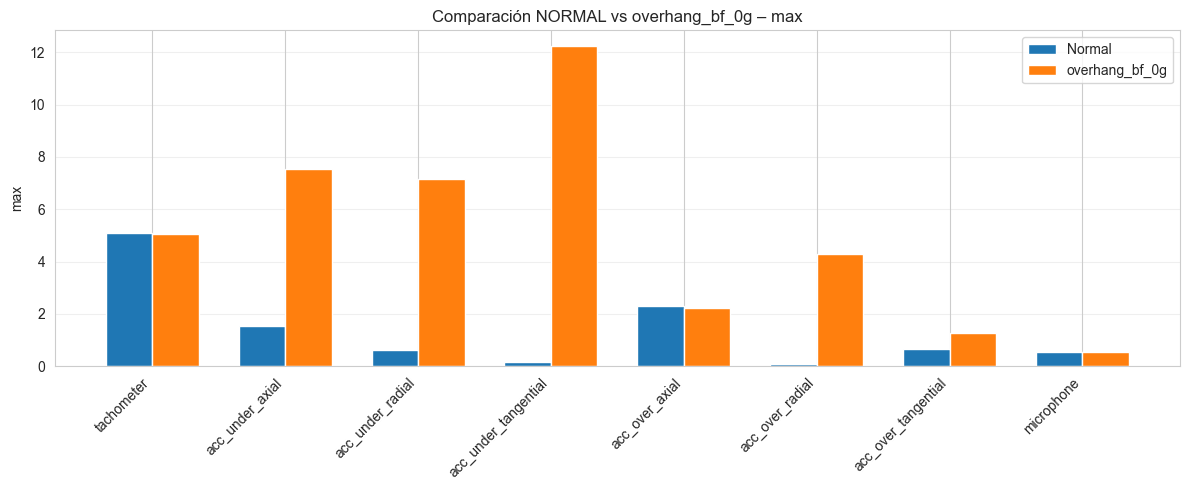

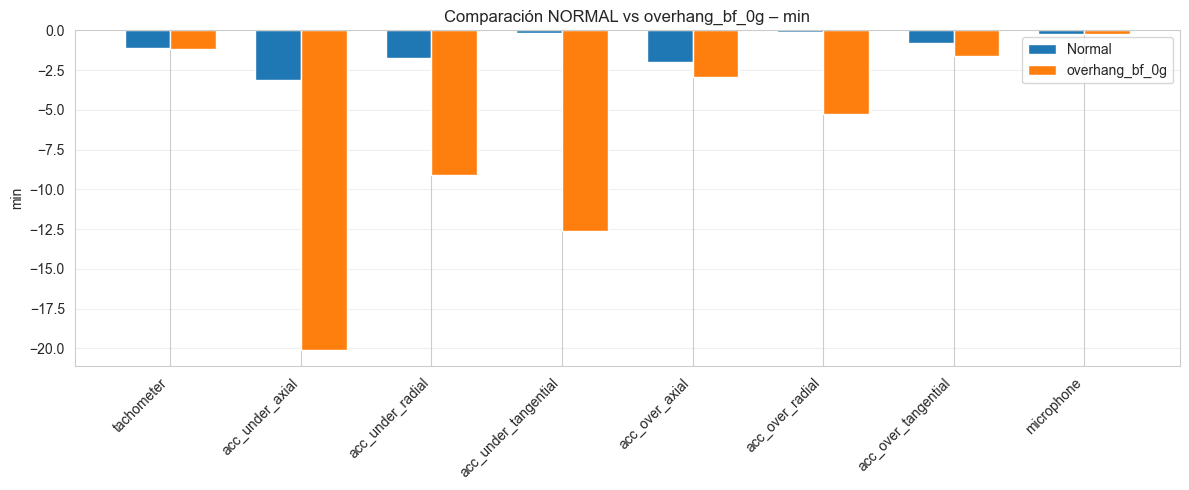

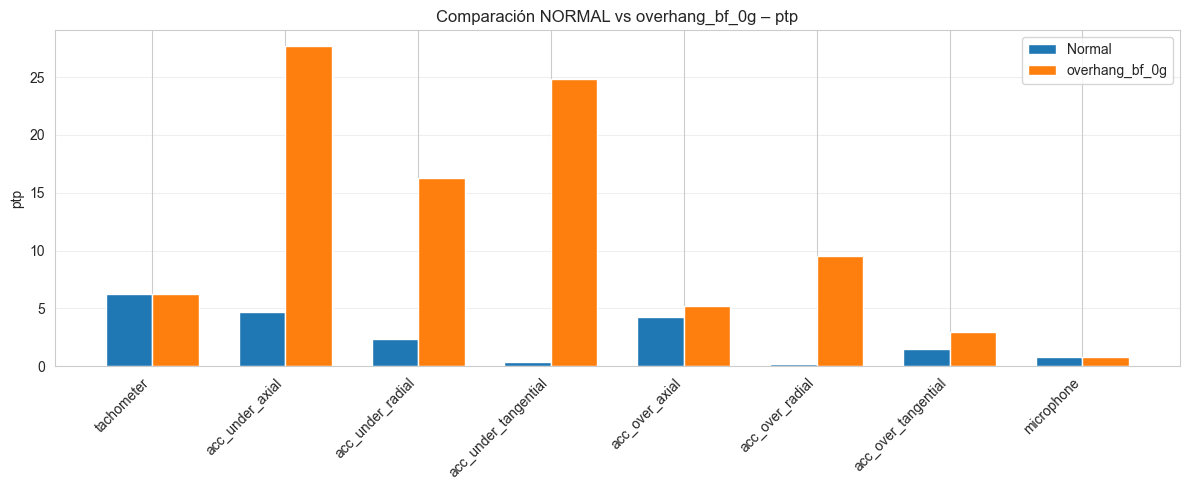

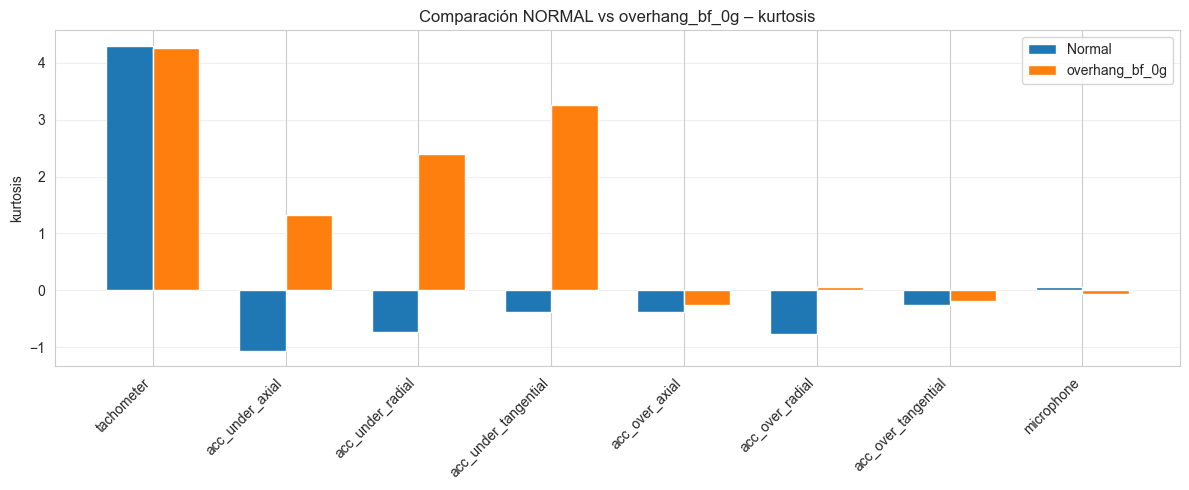

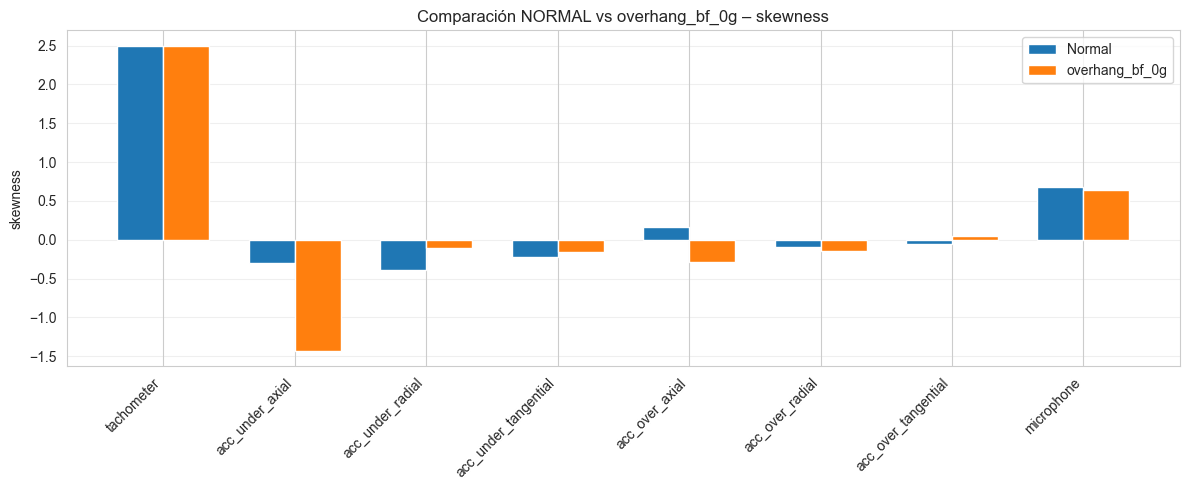

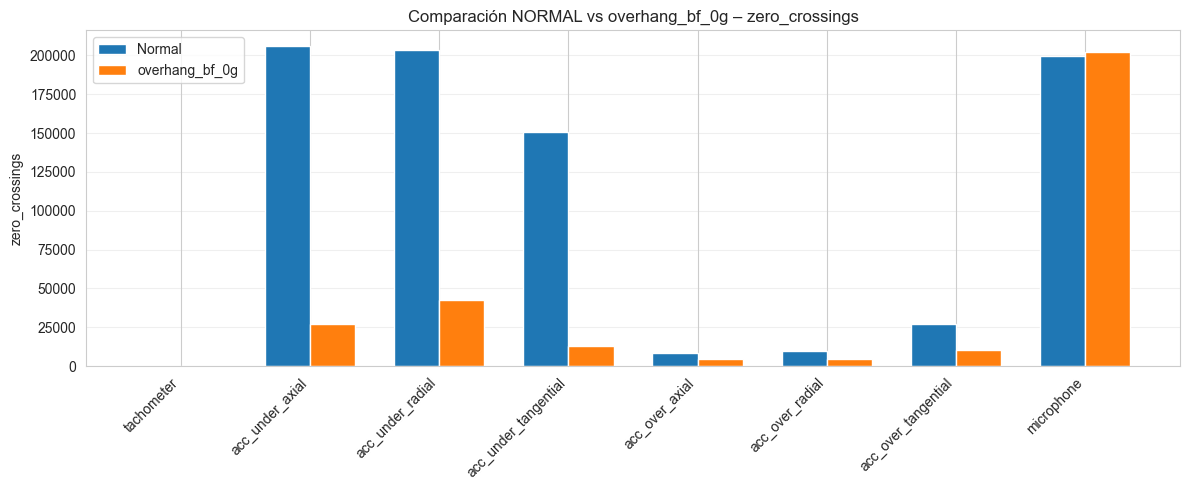

In [37]:
signals_by_condition = {
    "normal": normal_12288,
    "overhang_bf_0g": ov_bf_0g
}
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():
        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)
df_features

for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["overhang_bf_0g", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12, 5))

    plt.bar(x - width / 2, normal_vals, width, label="Normal")
    plt.bar(x + width / 2, imbalance_vals, width, label="overhang_bf_0g")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs overhang_bf_0g – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [38]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="overhang_bf_0g"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.018317416162845202

Característica: std
Sensor con mayor incremento: acc_under_axial
Incremento: 3.298030686525081

Característica: rms
Sensor con mayor incremento: acc_under_axial
Incremento: 3.2980557280805836

Característica: max
Sensor con mayor incremento: acc_under_tangential
Incremento: 12.05167

Característica: min
Sensor con mayor incremento: microphone
Incremento: 0.009099999999999997

Característica: ptp
Sensor con mayor incremento: acc_under_tangential
Incremento: 24.506210000000003

Característica: kurtosis
Sensor con mayor incremento: acc_under_tangential
Incremento: 3.640339314406385

Característica: skewness
Sensor con mayor incremento: acc_under_radial
Incremento: 0.29141265564067736

Característica: zero_crossings
Sensor con mayor incremento: microphone
Incremento: 2805



# Underhang

In [39]:
# Cargar CSV SIN header y asignar nombres
un_bf_0g = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"underhang"/"ball_fault"/"0g"/"13.1072.csv",
    header=None,
    names=sensor_names)

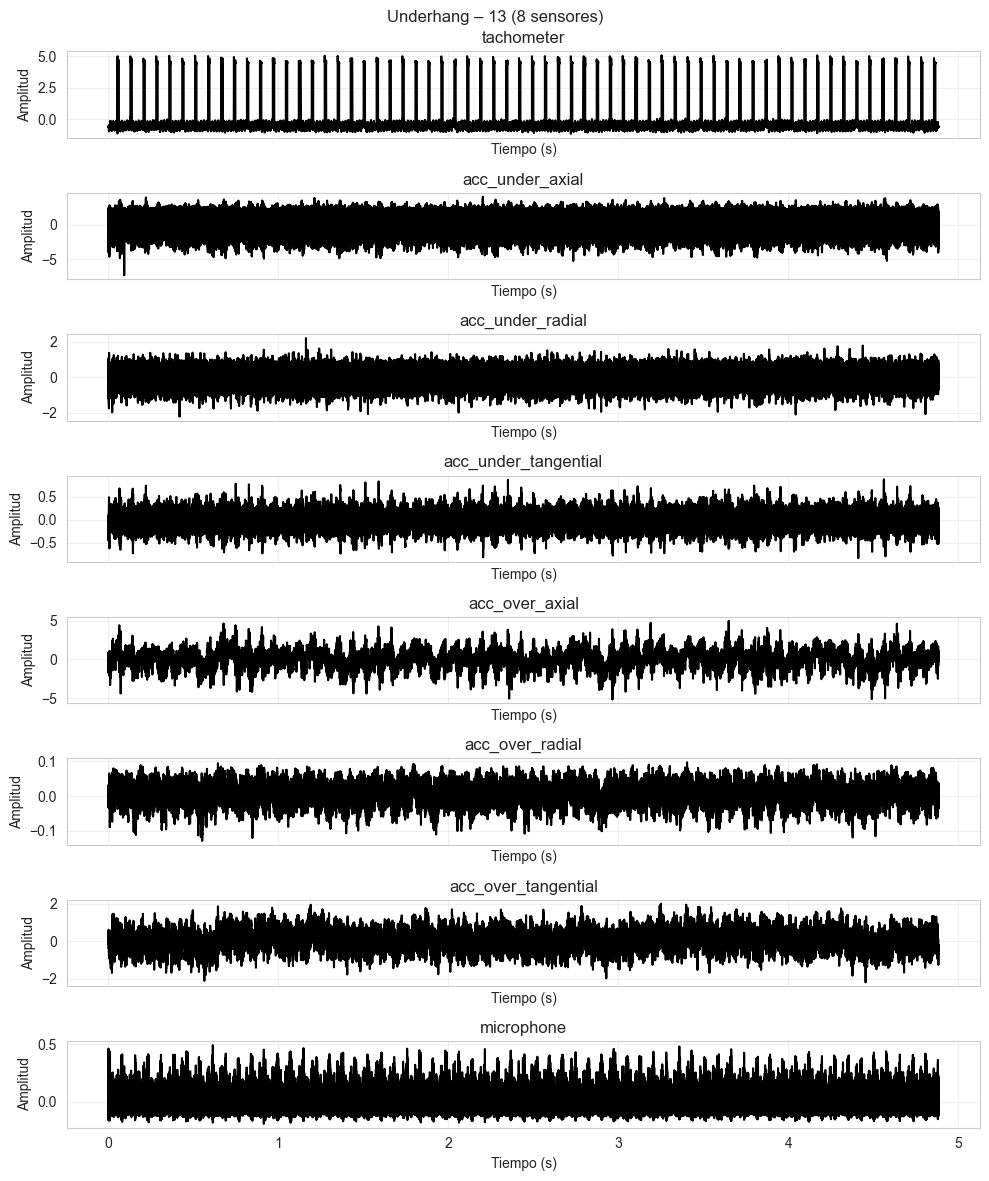

In [40]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(un_bf_0g.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, un_bf_0g.columns):
    run_sequence_plot(
        temporal,
        un_bf_0g[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Underhang – 13 (8 sensores)")
plt.tight_layout()
plt.show()

## Comparación normal vs Underhang

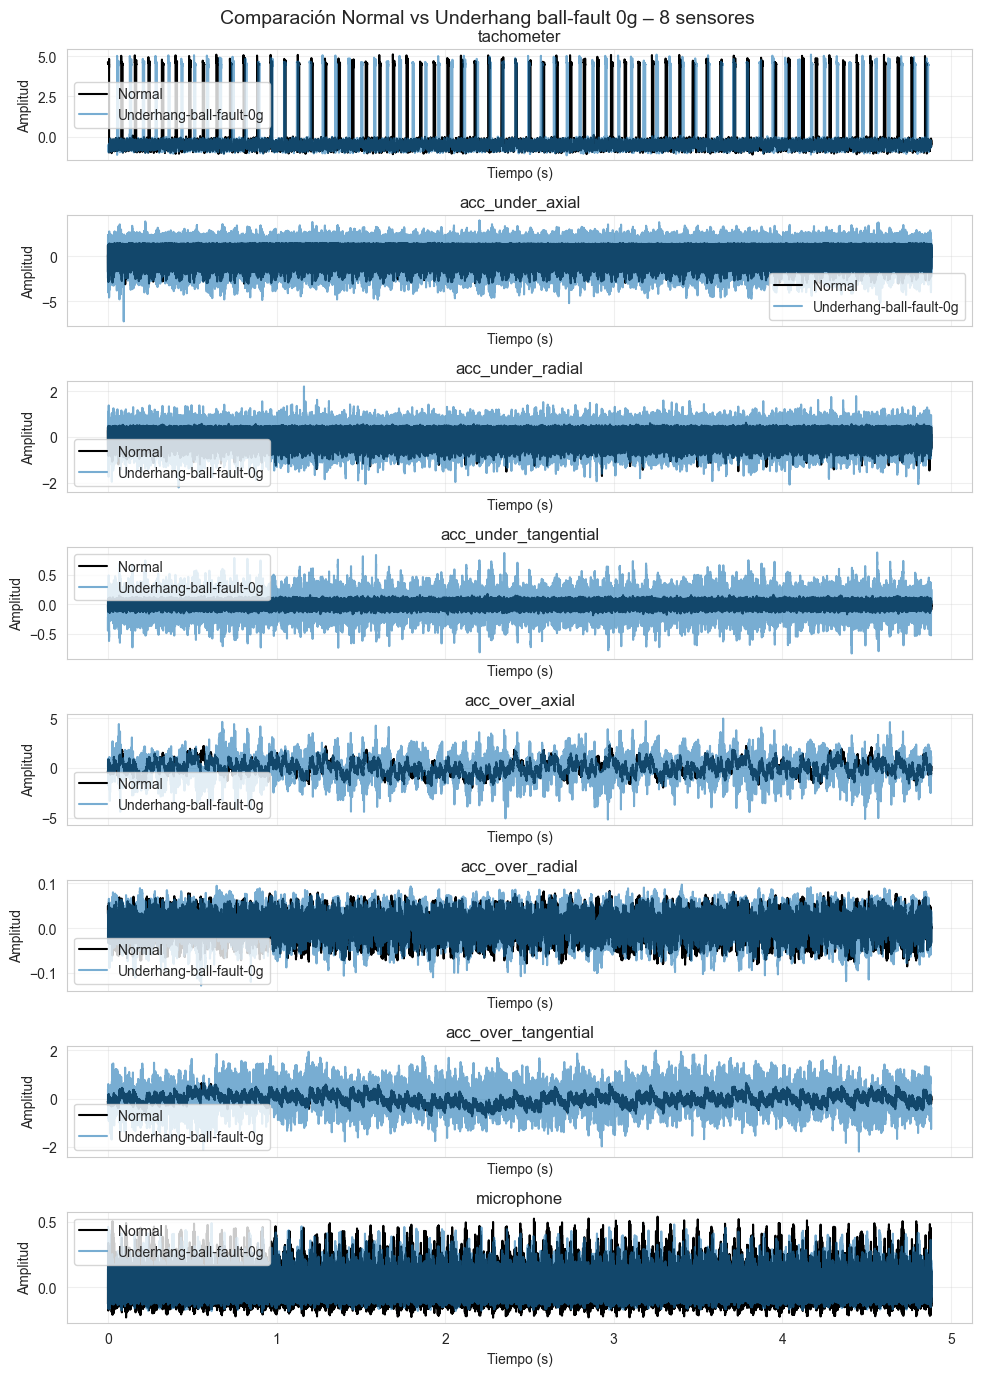

In [41]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        un_bf_0g[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Underhang-ball-fault-0g"])

fig.suptitle("Comparación Normal vs Underhang ball-fault 0g – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

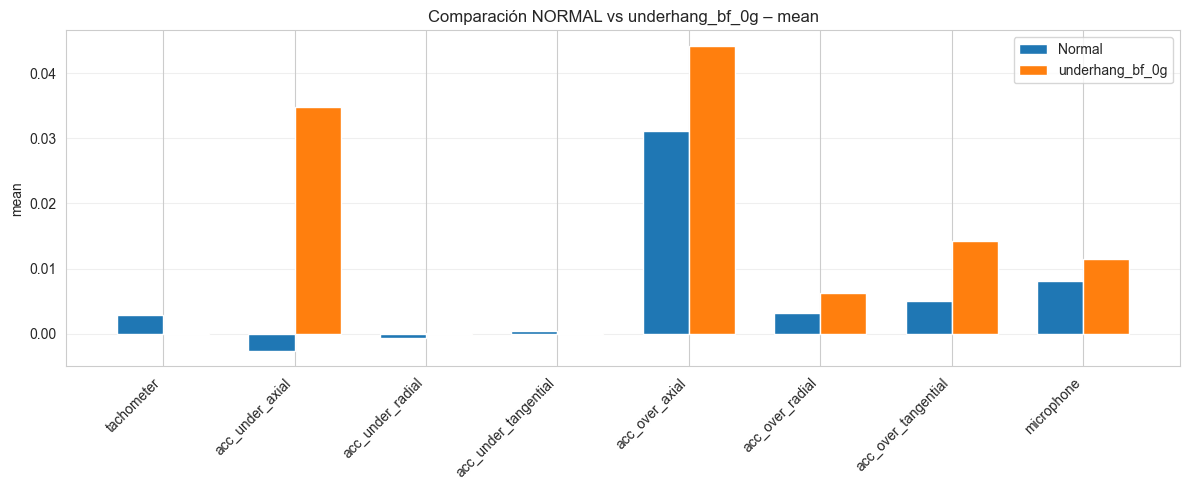

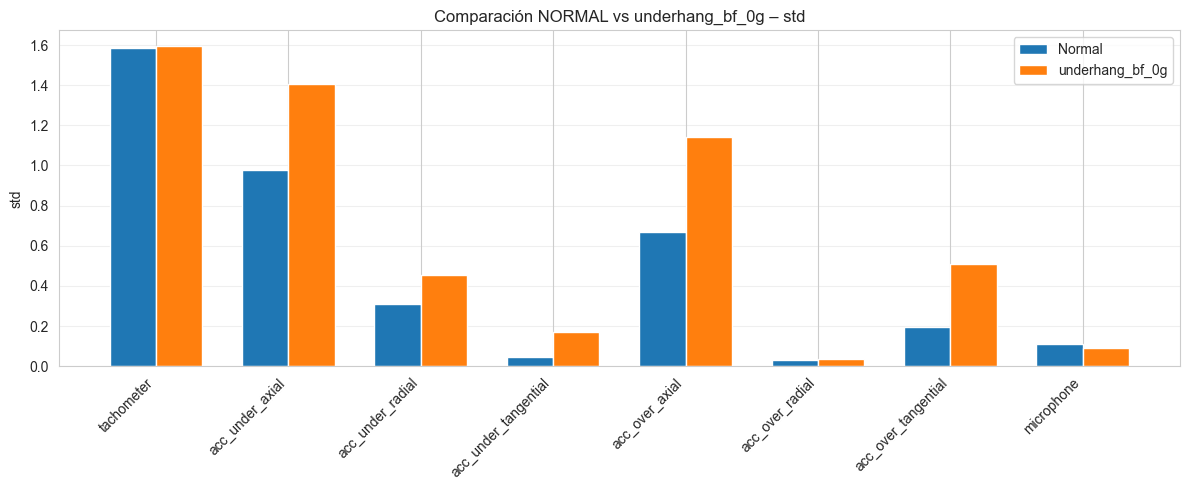

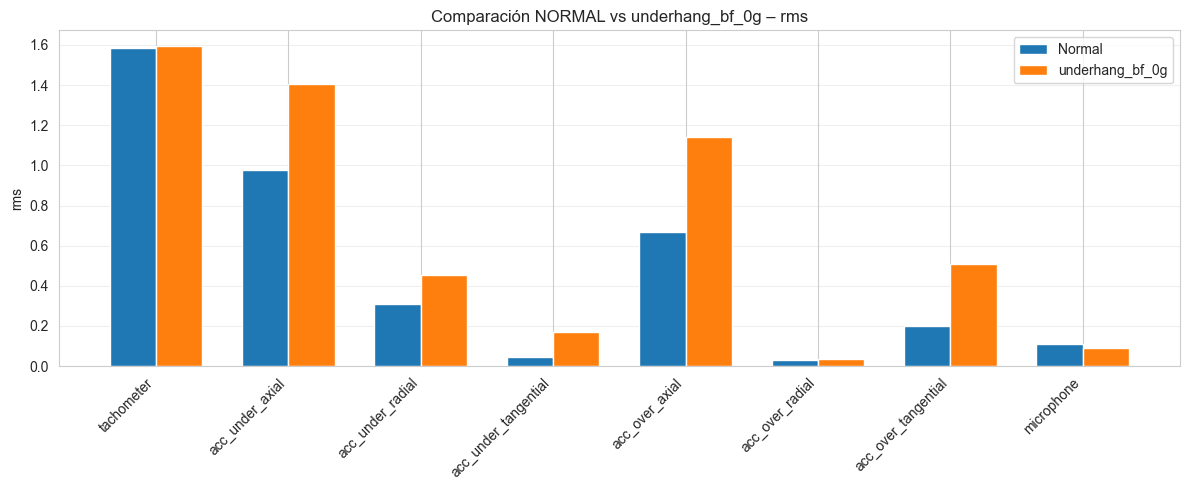

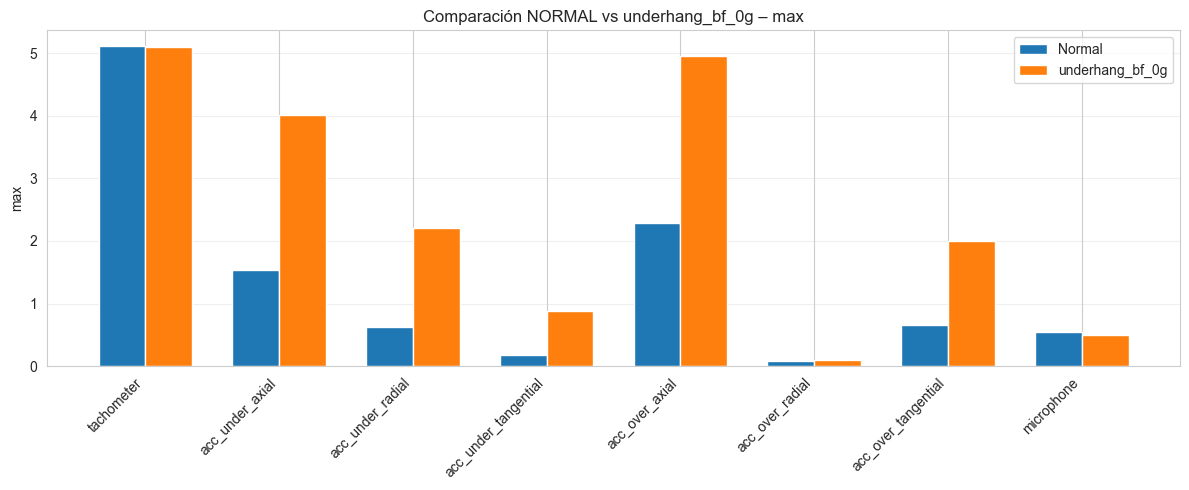

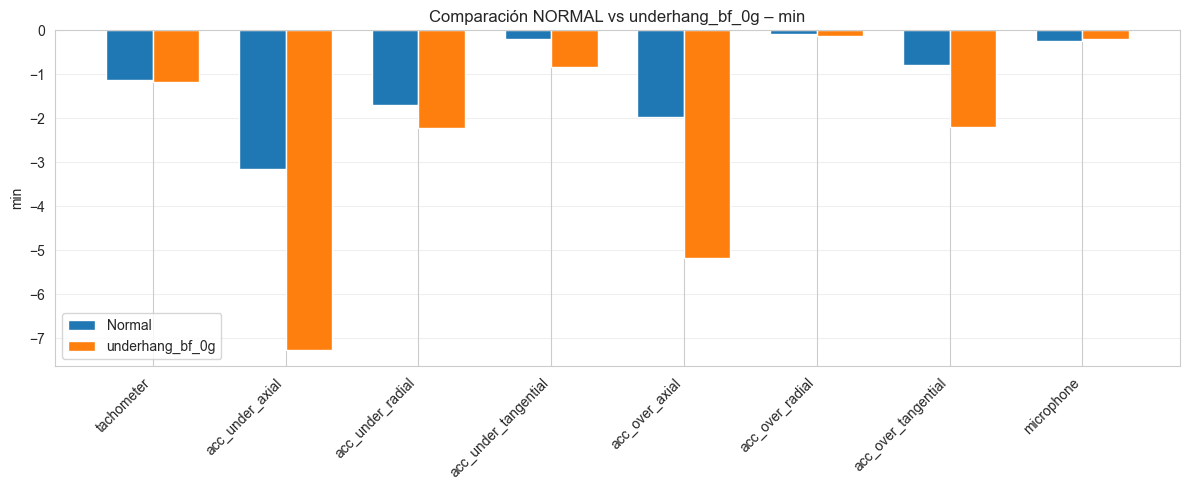

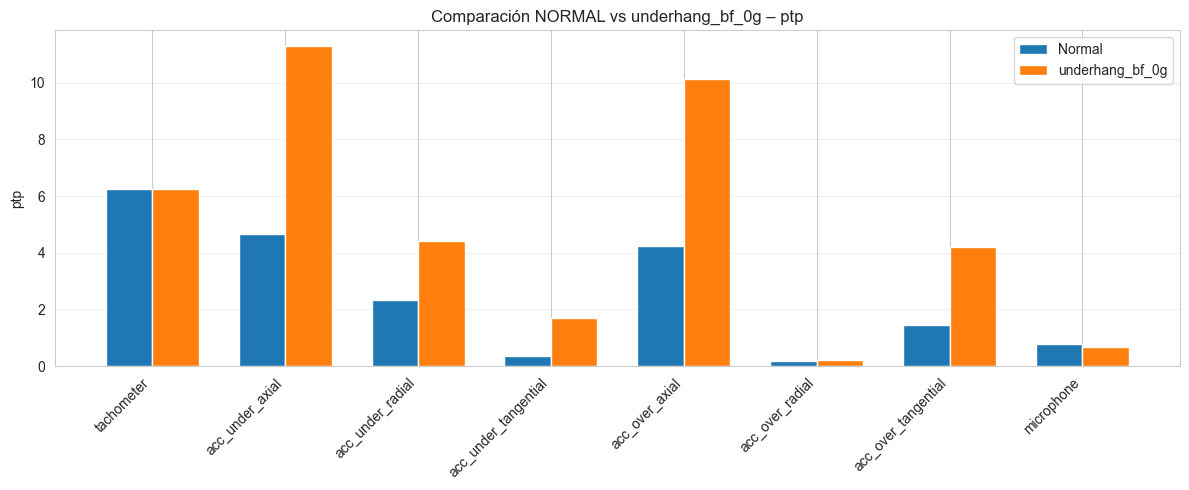

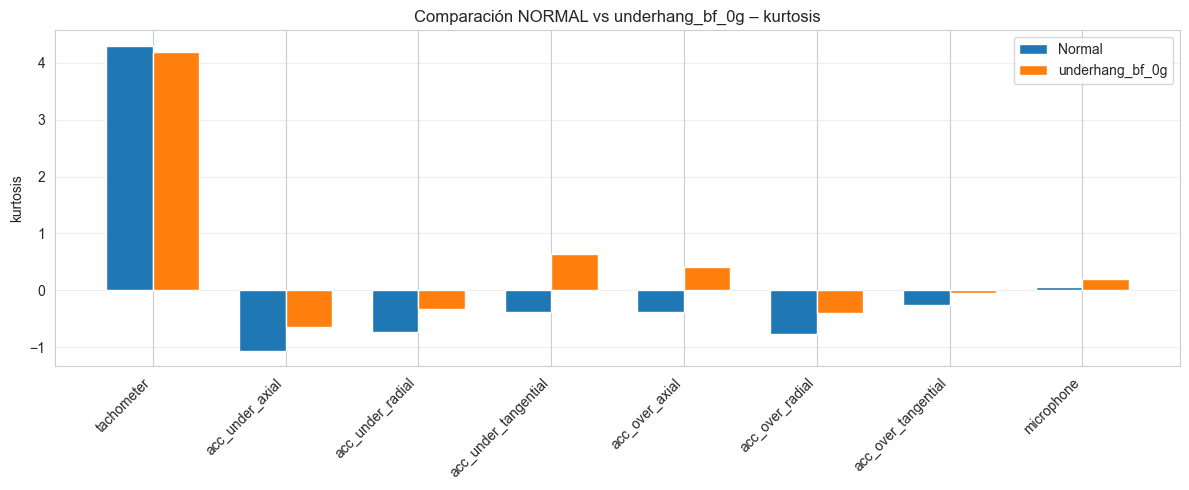

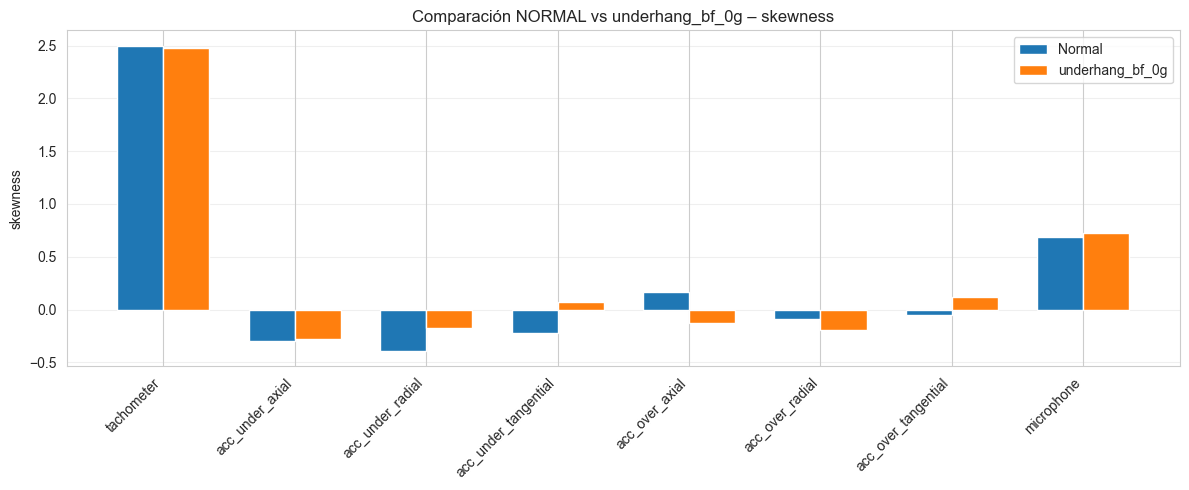

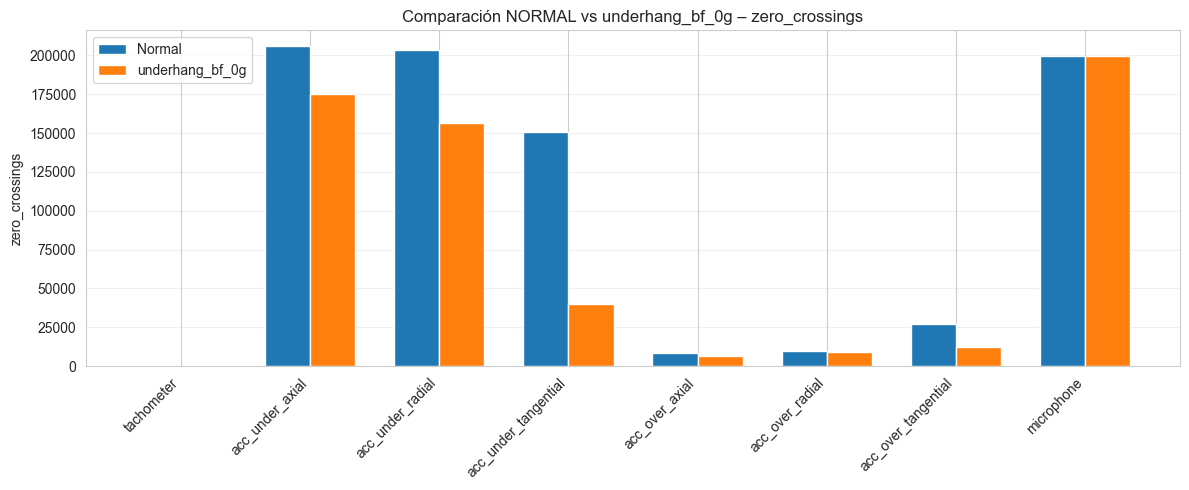

In [42]:
signals_by_condition = {
    "normal": normal_12288,
    "underhang_bf_0g": un_bf_0g
}
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():
        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)
df_features

for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["underhang_bf_0g", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12, 5))

    plt.bar(x - width / 2, normal_vals, width, label="Normal")
    plt.bar(x + width / 2, imbalance_vals, width, label="underhang_bf_0g")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs underhang_bf_0g – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [43]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="underhang_bf_0g"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.037492380213991996

Característica: std
Sensor con mayor incremento: acc_over_axial
Incremento: 0.47220399858871864

Característica: rms
Sensor con mayor incremento: acc_over_axial
Incremento: 0.4723401196930096

Característica: max
Sensor con mayor incremento: acc_over_axial
Incremento: 2.6727

Característica: min
Sensor con mayor incremento: microphone
Incremento: 0.040449999999999986

Característica: ptp
Sensor con mayor incremento: acc_under_axial
Incremento: 6.6114

Característica: kurtosis
Sensor con mayor incremento: acc_under_tangential
Incremento: 1.0085941140913275

Característica: skewness
Sensor con mayor incremento: acc_under_tangential
Incremento: 0.29018921285606347

Característica: zero_crossings
Sensor con mayor incremento: tachometer
Incremento: 9

